In [ ]:
"""installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


'installs'

In [ ]:
import sys
from pathlib import Path

# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


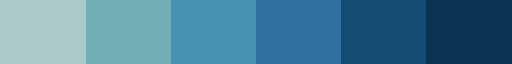

In [ ]:
import scicolor

scicolor.get_cmap("Hokusai2")


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, MultiPolygon
import requests
from shapely.geometry import Point
import json
from collections import Counter

from transliterate import translit
import scripts_old.model as model
import scripts_old.provision as provision
import seaborn as sns
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import os
from tqdm import tqdm

tqdm.pandas()

from constants import *


In [ ]:
def fix_missing_capacity(row):
    """this is just a very straight forward workaround"""
    if row["population"] > 10e3 and row[f"capacity_{SERVICE_NAME}"] == 0:
        row[f"capacity_{SERVICE_NAME}"] = row["population"] / 2

    return int(row[f"capacity_{SERVICE_NAME}"])


def make_block_scheme(settl, df_service):
    blocks_gdf = model.create_blocks(
        settl, const_demand=CONST_BASE_DEMAND, epsg=MERCATOR_CRS
    )
    blocks_gdf = model.update_blocks_with_services(
        blocks_gdf, df_service, service_type=SERVICE_NAME
    )
    # Добавим колонку с транслитерированными именами
    blocks_gdf["name"] = blocks_gdf["name"].apply(
        lambda x: translit(x, "ru", reversed=True)
    )

    blocks_gdf[f"capacity_{SERVICE_NAME}"] = blocks_gdf.apply(
        fix_missing_capacity, axis=1
    )
    blocks_gdf = blocks_gdf.to_crs(MERCATOR_CRS)
    return blocks_gdf


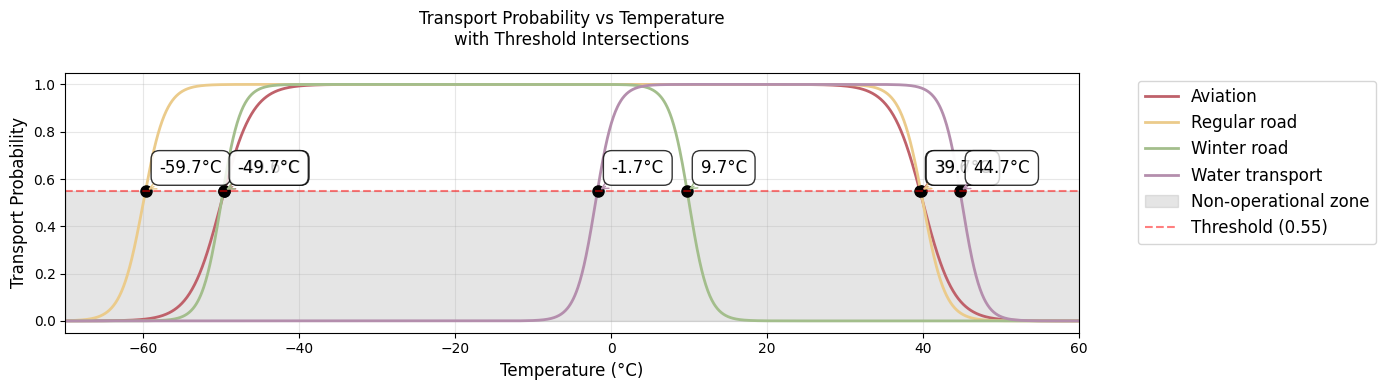

In [6]:
from plotter_transport_mode_prob import plot_transport_probability_legacy
from calculator_transport_prob import get_transport_probability

threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


In [ ]:
"""
Добавить параллельно две карты:
- Распределение сервисов каждой группы (вместе? как кружками?) по нп
"""


'\nДобавить параллельно две карты:\n- Распределение сервисов каждой группы (вместе? как кружками?) по нп\n'

========== yakut_chuk ==========
|||||||||||||||||||| school ||||||||||||||||||||


Running network analysis: 100%|██████████| 516/516 [00:32<00:00, 15.83it/s]


Input threshold_temperatures: {'Aviation': [(np.float64(-49.6), np.float64(39.6))], 'Regular road': [(np.float64(-59.7), np.float64(39.7))], 'Winter road': [(np.float64(-49.7), np.float64(9.7))], 'Water transport': [(np.float64(-1.7), np.float64(44.7))]}
Detected operational ranges format - using directly
Final operational_ranges: {'Aviation': [(-49.6, 39.6)], 'Regular road': [(-59.7, 39.7)], 'Winter road': [(-49.7, 9.7)], 'Water transport': [(-1.7, 44.7)]}


/Users/test/Documents/code/iccs25/new_notebooks/plotter_heatmap_prov_node.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=tight_layout_rect)


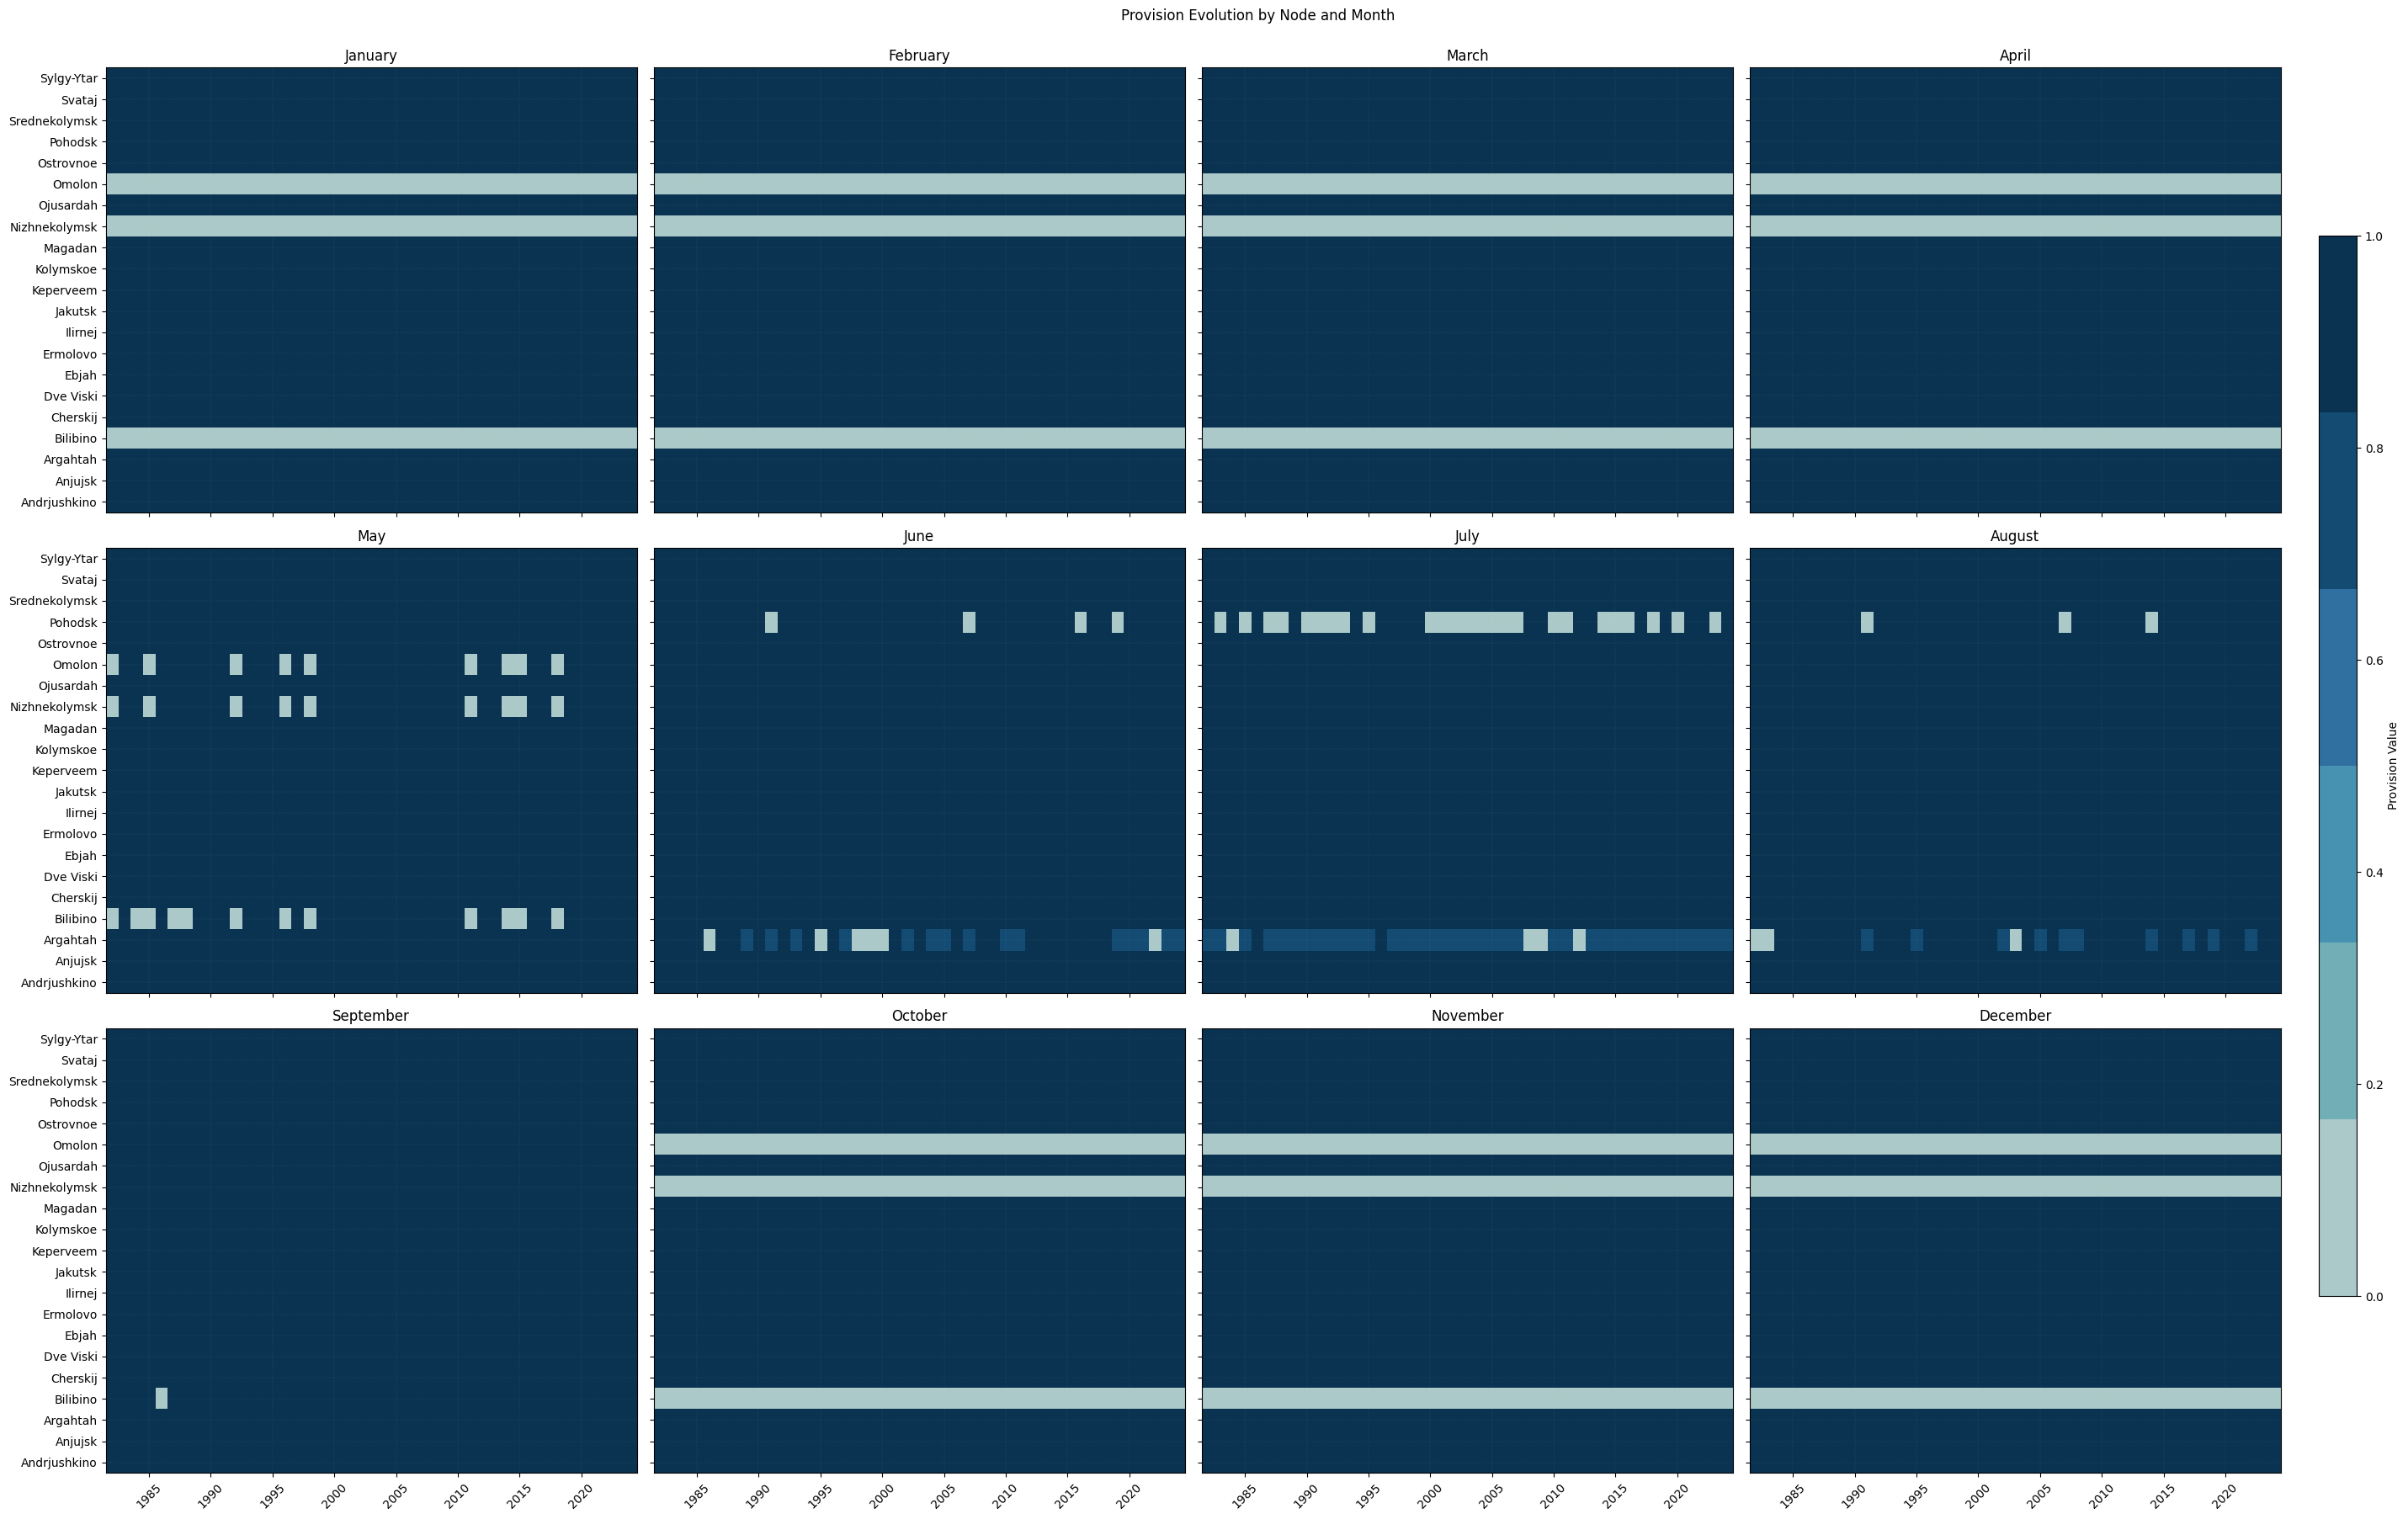

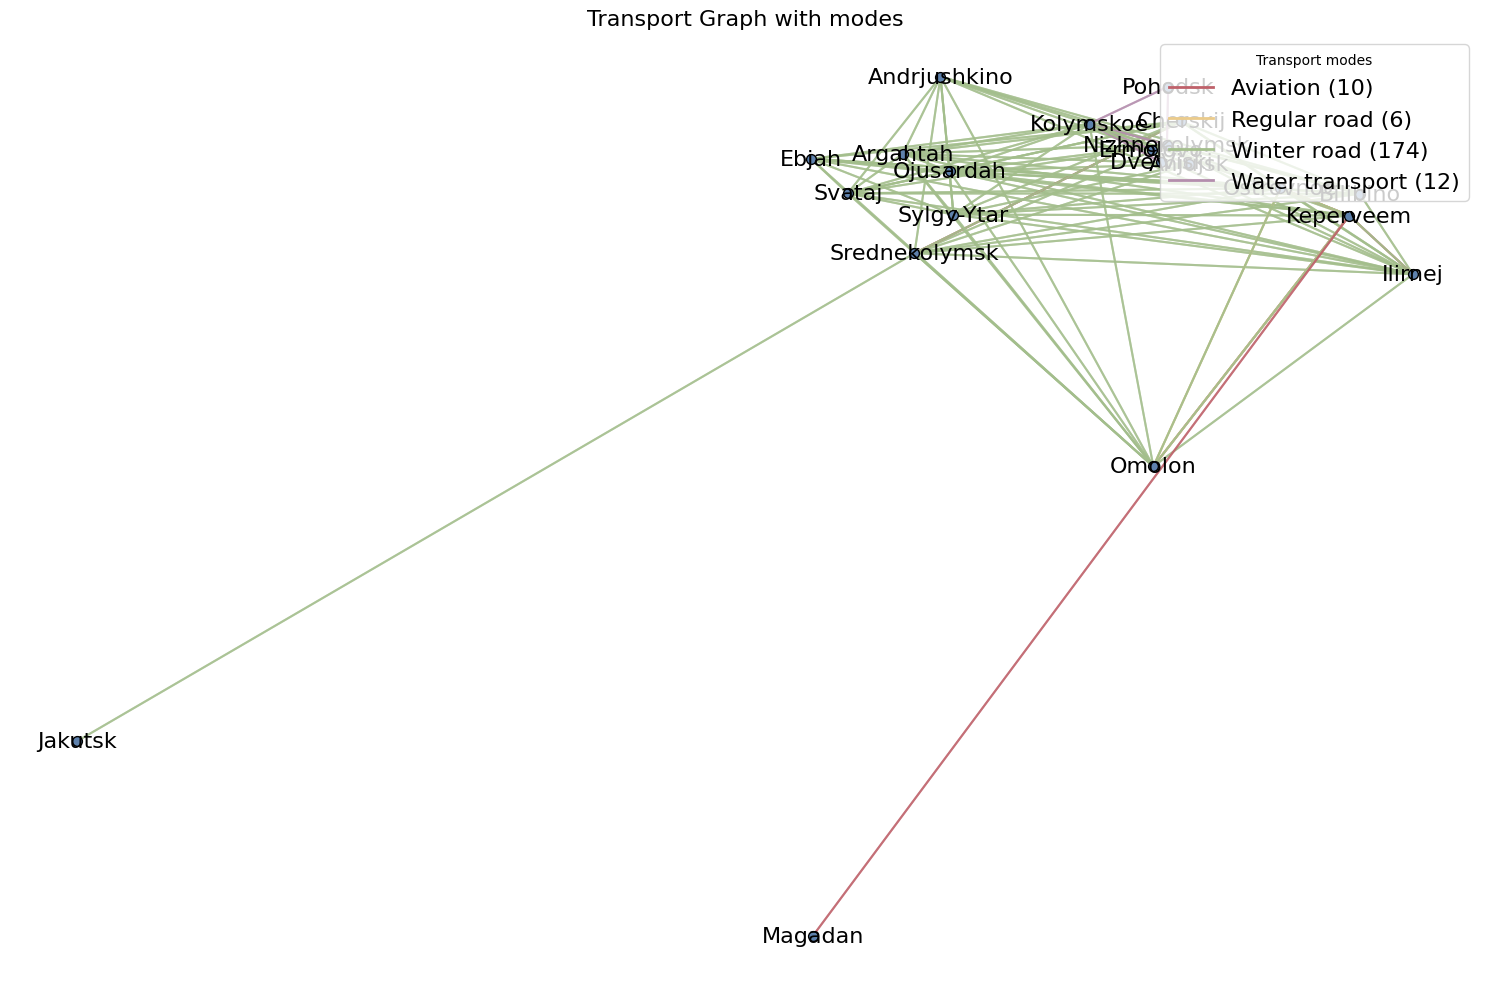

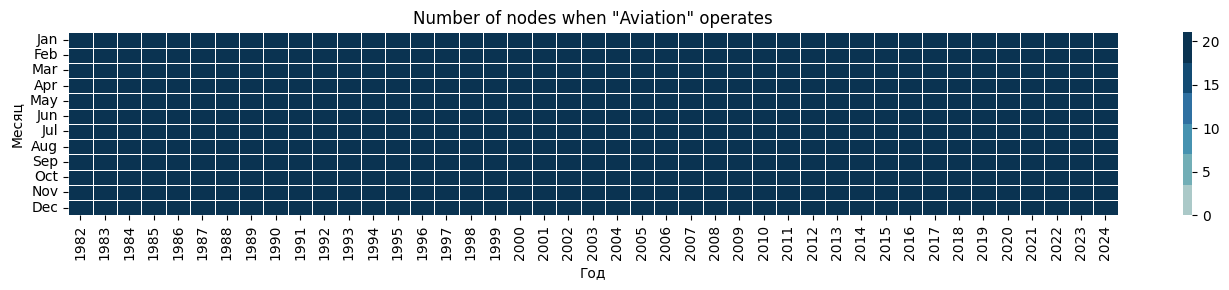

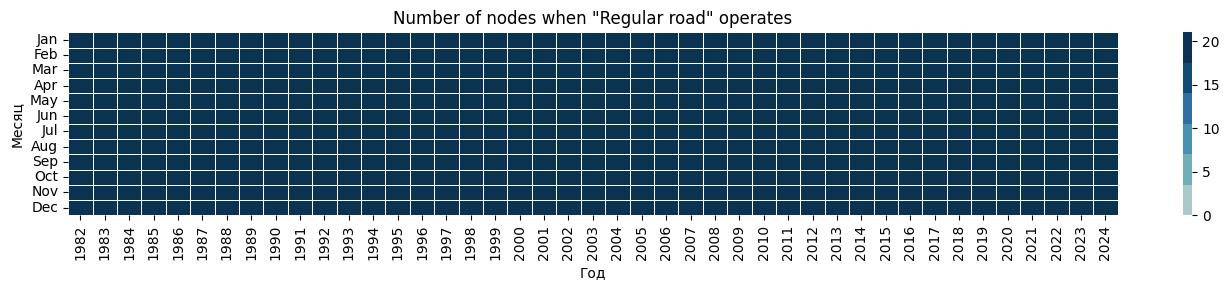

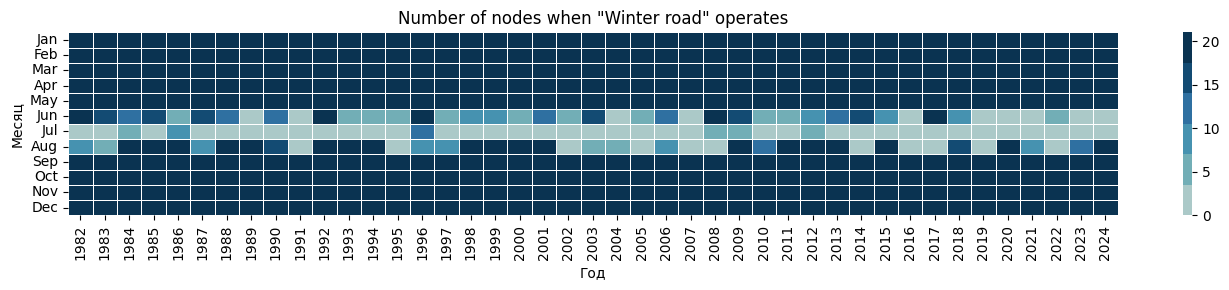

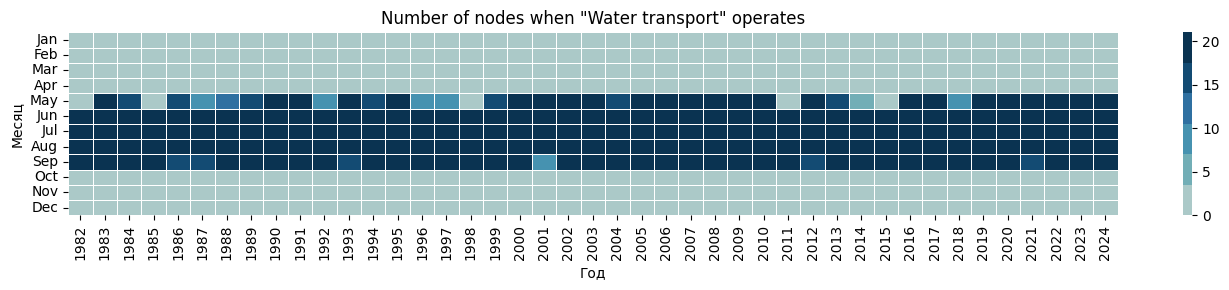

In [9]:
from preprocesser import get_data
from gcreator import make_g, add_temp_to_g
from plotter_network_basic import plot_transport_graph
from huston import call_nasa
from calculator_stat import create_agglomeration_network
from calculator_monthly_mode import create_df_modes_monthly_fixed
from plotter_heatmap import create_transport_mode_heatmaps
from plotter_heatmap_prov_node import plot_provision_evolution_by_node

# SETTL_NAME = "mezen"
# SERVICE_NAME = "health"

for SETTL_NAME in ["yakut_chuk"]:

    print(
        "=" * 10,
        SETTL_NAME,
        "=" * 10,
    )
    for SERVICE_NAME in ["school"]:
        print(
            "||" * 10,
            SERVICE_NAME,
            "||" * 10,
        )

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )
        blocks_gdf = make_block_scheme(settl, df_service)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        range_year = range(
            list(G_undirected.nodes(data=True))[0][1]["temperature"].shape[0]
        )

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_year,
            service_radius_minutes=SERVICE_RADIUS_MINUTES,
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=12,
        )

        plot_provision_evolution_by_node(net.stats.results, START_YEAR)
    plot_transport_graph(
        G_undirected, figsize=(15, 10), title="Transport Graph with modes"
    )
    create_transport_mode_heatmaps(
        df_modes_monthly=df_modes_monthly,
        transport_modes=transport_modes,
        month_order=month_order,
        max_nodes=len(G_undirected.nodes),
    )


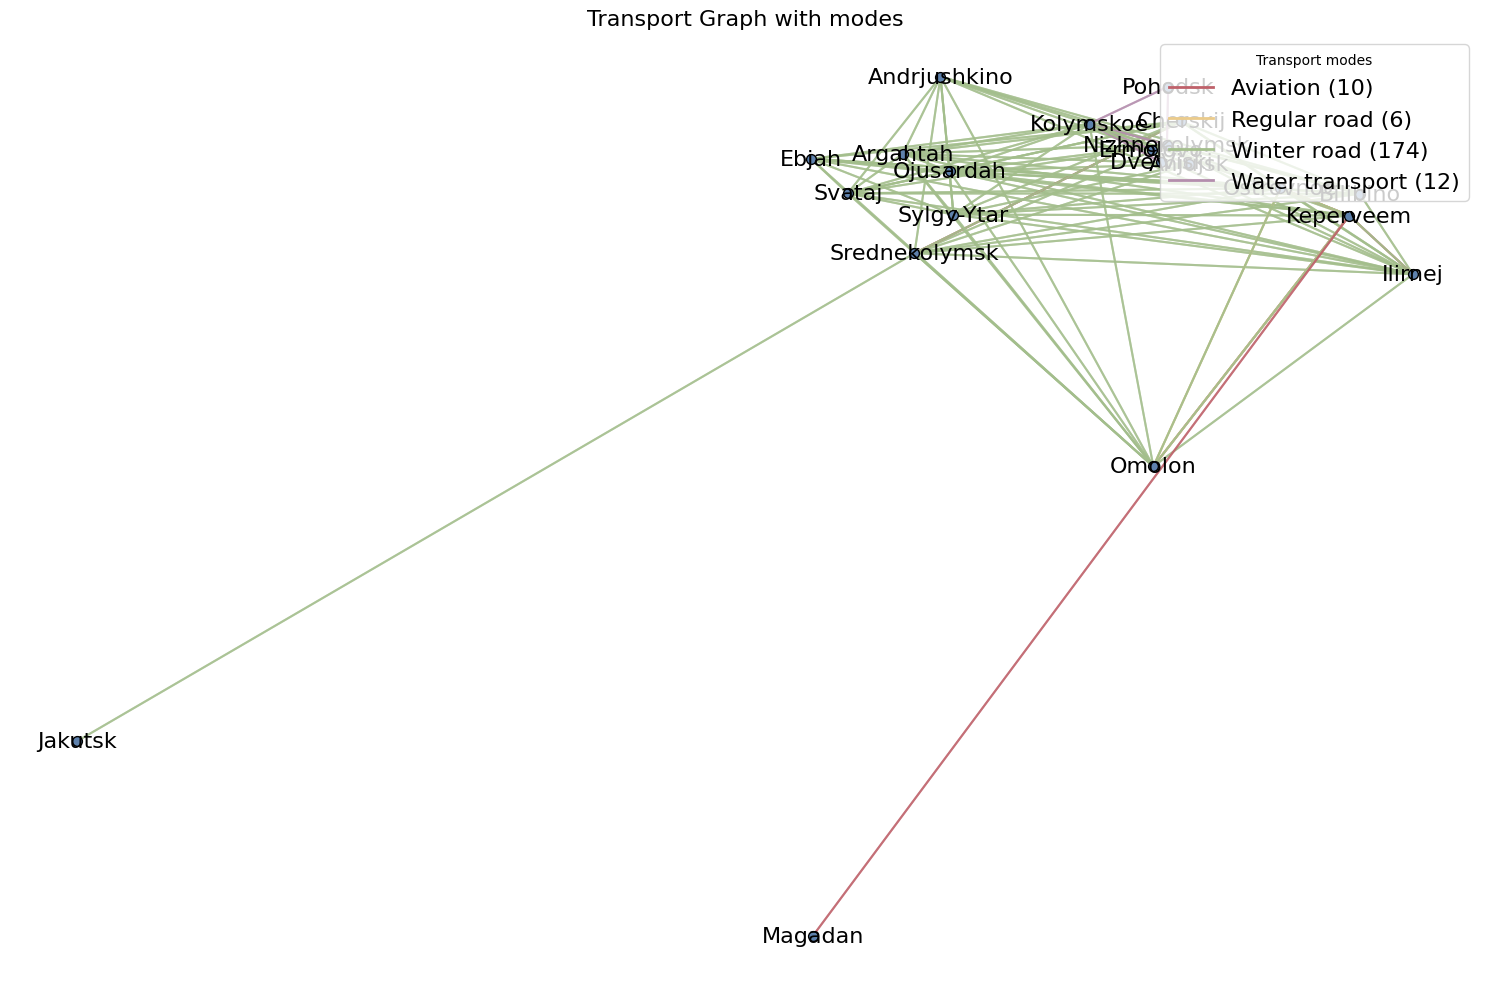

In [10]:
plot_transport_graph(G_undirected, figsize=(15, 10), title="Transport Graph with modes")


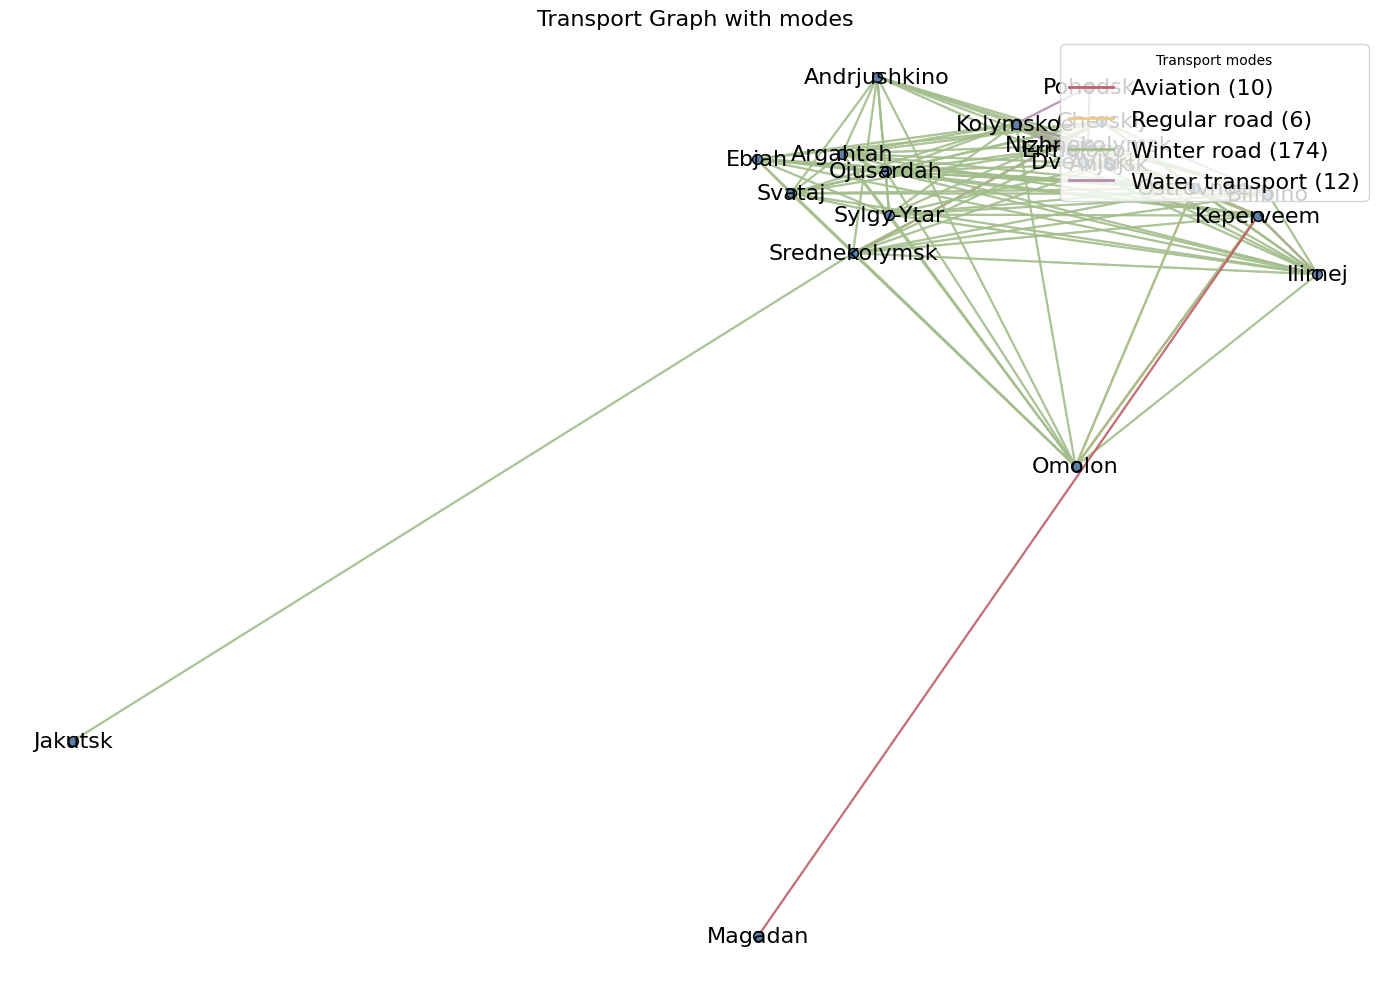

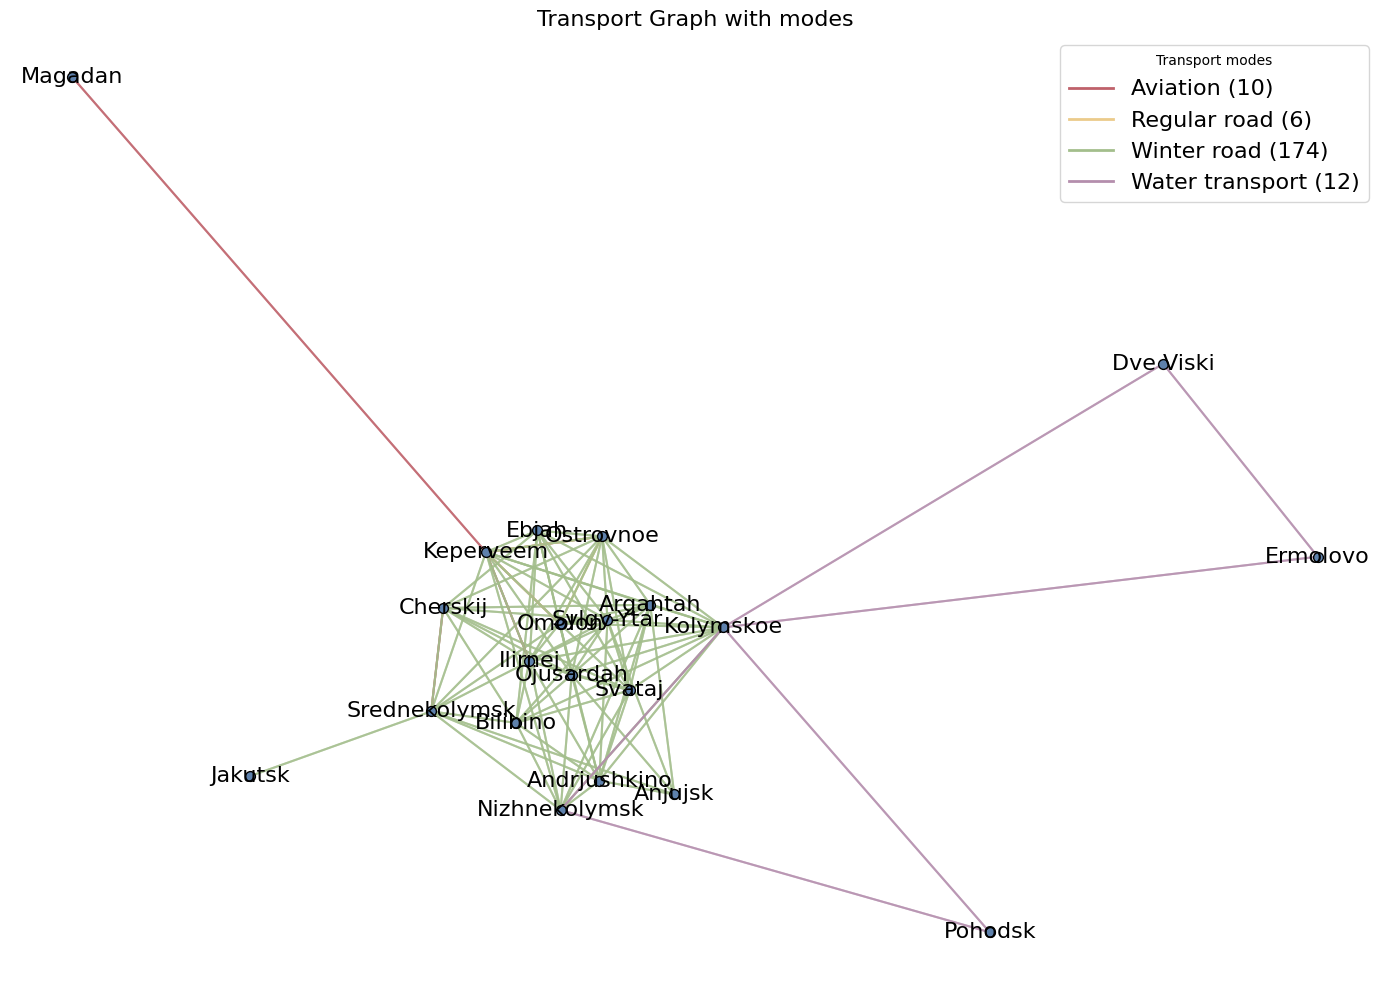

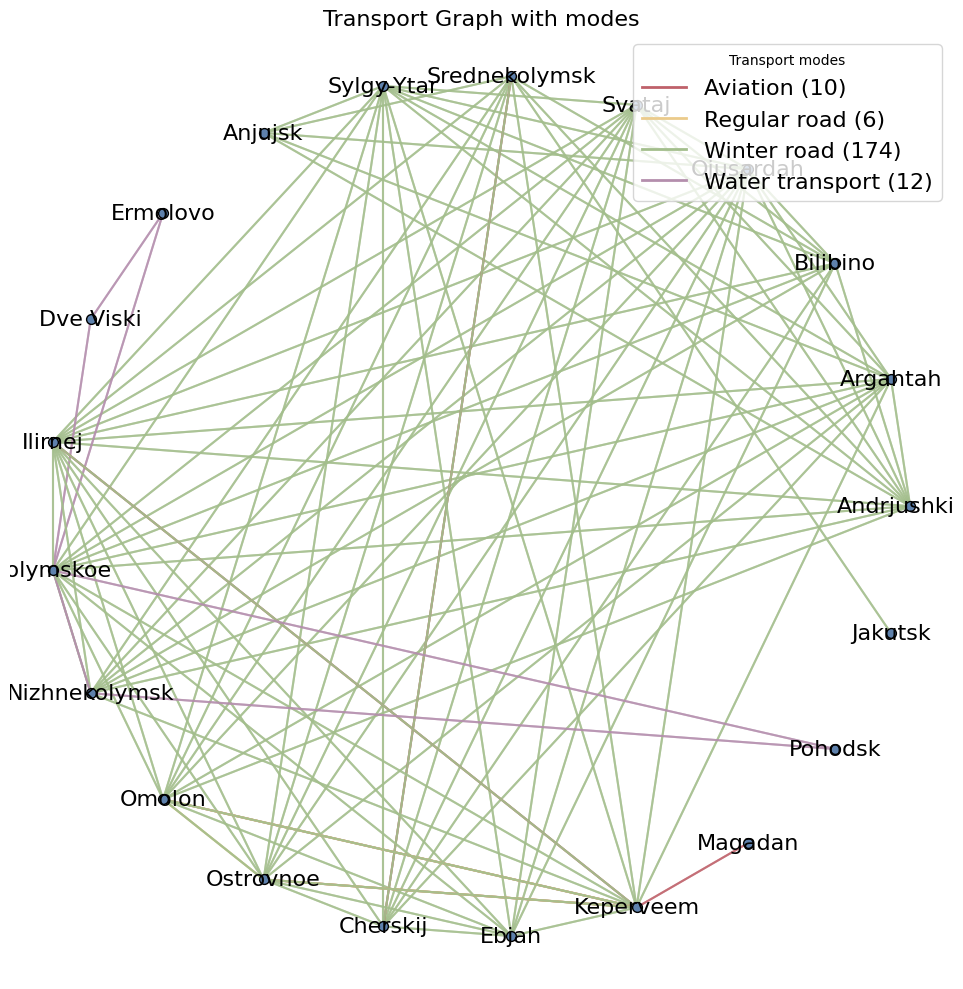

In [13]:
plot_transport_graph(
    G_undirected, use_geo_layout=True
)  # С географическими координатами
plot_transport_graph(
    G_undirected, use_geo_layout=False, layout_algorithm="spring"
)  # Spring layout
plot_transport_graph(
    G_undirected, use_geo_layout=False, layout_algorithm="circular"
)  # Spring layout


In [ ]:
"""
Гистограммы распределения времени по ребрам
 + относительно норматива по времени (для сервиса)
"""


'\nГистограммы распределения времени по ребрам\n + относительно норматива по времени (для сервиса)\n'

In [ ]:
"""
Хочется (однозначно) понять
как пропадают линки от температуры
Всм не картой сети а графиком
Где скажем есть какая-то температура например для ноды (в течение года(?))
И на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)
"""


'\nХочется (однозначно) понять\nкак пропадают линки от температуры\nВсм не картой сети а графиком\nГде скажем есть какая-то температура например для ноды (в течение года(?))\nИ на ней же отмечено когда существует тип транспорта (или любой, или для этой ноды)\n'

In [ ]:
"""
Хочется показать (при рассм одного сервиса)
Какие линки появляются *иногда* в зависимости от изменения температуры
Или наоборот исчезают (?)
"""


'\nХочется показать (при рассм одного сервиса)\nКакие линки появляются *иногда* в зависимости от изменения температуры\nИли наоборот исчезают (?)\n'

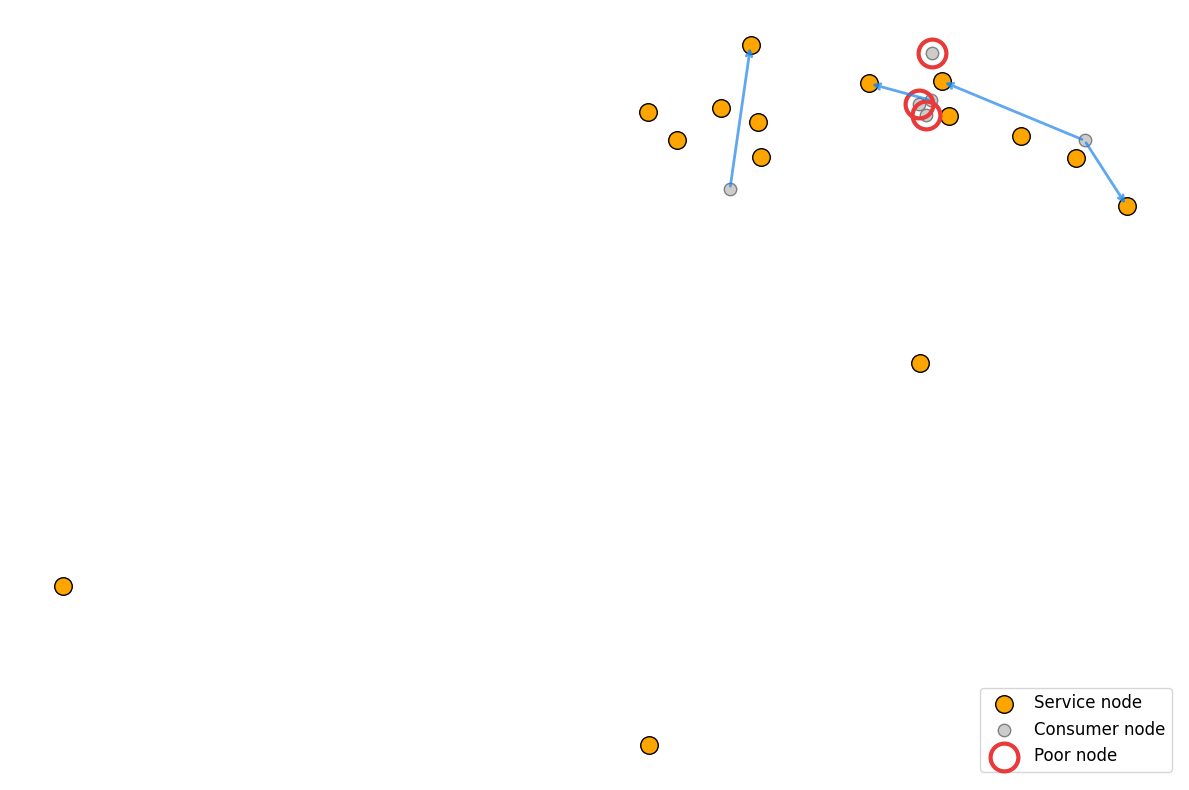

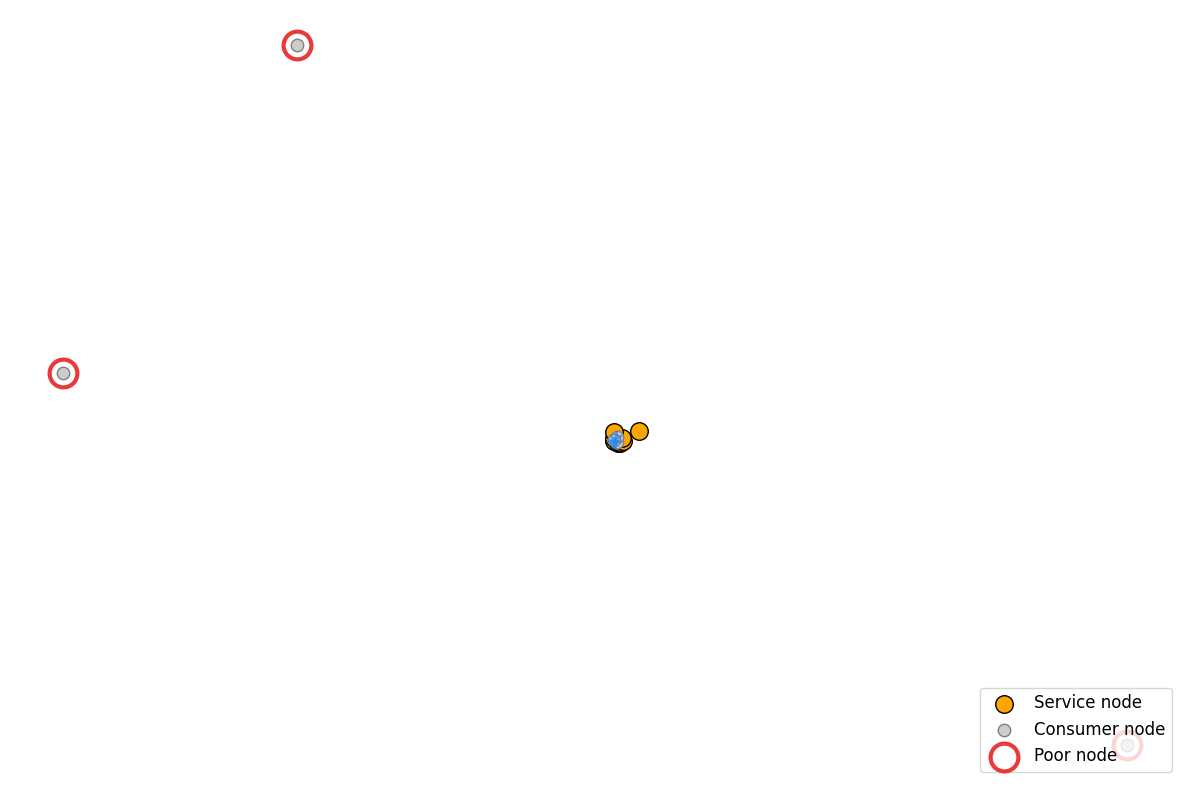

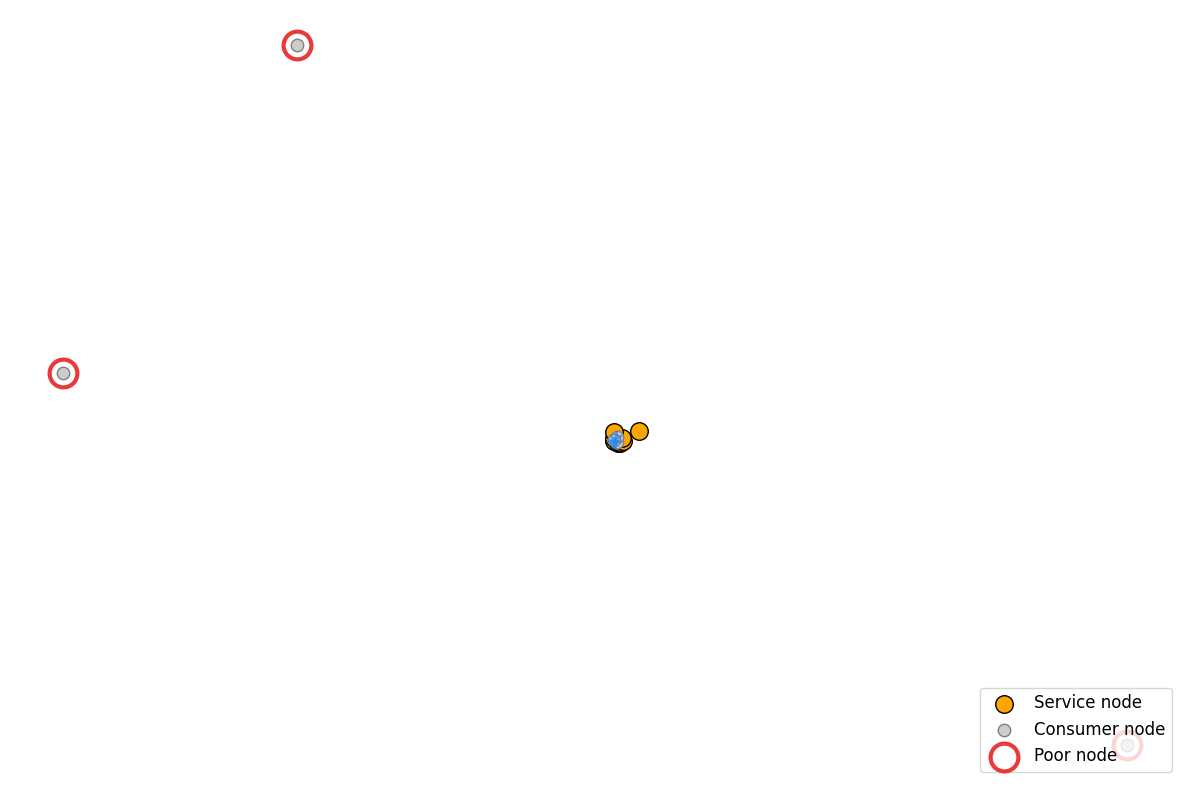

In [ ]:
from plotter_network import (
    plot_with_geographic_layout,
    plot_with_spring_layout,
    plot_with_saved_layout,
)

# Geographic layout (original behavior)
layout = plot_with_geographic_layout(
    net.stats.graphs[0], capacity_field=f"capacity_{SERVICE_NAME}", return_layout=True
)

# Spring layout
layout = plot_with_spring_layout(
    net.stats.graphs[0], capacity_field=f"capacity_{SERVICE_NAME}", return_layout=True
)

# Reuse saved layout
plot_with_saved_layout(
    net.stats.graphs[0], pos=layout, capacity_field=f"capacity_{SERVICE_NAME}"
)


In [ ]:
# for u, v, data in net.stats.graphs[0].edges(data=True):
#     print(u,v,data)


In [ ]:
# import community as community_louvain  # pip install python-louvain
# from networkx.algorithms.community import girvan_newman

# G = net.stats.graphs[month_idx]
# G_undirected = G.to_undirected()


# # 2. Assign colors to communities
# import matplotlib.pyplot as plt
# import networkx as nx

# # 1. Louvain community detection
# partition = community_louvain.best_partition(G_undirected)
# # communities = set(partition.values())


# colors = plt.cm.tab10.colors  # Up to 10 unique colors
# node_colors = [colors[partition[n] % len(colors)] for n in G_undirected.nodes()]

# # 3. Plot
# pos = {n: (d["x"], d["y"]) for n, d in G_undirected.nodes(data=True)}
# plt.figure(figsize=(12, 6))
# nx.draw(
#     G_undirected,
#     pos,
#     node_color=node_colors,
#     with_labels=True,
#     edge_color="#cccccc",
#     node_size=120,
#     linewidths=1,
#     font_size=10,
# )
# plt.title("Louvain Communities")
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx

# G_directed = net.stats.graphs[month_idx].copy()
# G_directed.remove_edges_from(nx.selfloop_edges(G_directed))

# # Calculate in-degree for each node
# in_degrees = dict(G_directed.in_degree())
# min_deg, max_deg = min(in_degrees.values()), max(in_degrees.values())
# node_sizes = [
#     2e2 * (in_degrees[n] - min_deg) / (max_deg - min_deg + 1e-9)
#     for n in G_directed.nodes()
# ]
# node_colors = [in_degrees[n] for n in G_directed.nodes()]
# pos = {
#     n: (d["x"], d["y"]) for n, d in G_directed.nodes(data=True) if "x" in d and "y" in d
# }

# plt.figure(figsize=(15, 10))
# nx.draw_networkx_edges(
#     G_directed,
#     pos,
#     edge_color="#cccccc",
#     width=1,
#     arrows=True,
#     arrowstyle="-|>",
#     arrowsize=18,
#     connectionstyle="arc3,rad=0.05",  # slight curve for visibility
# )
# nodes = nx.draw_networkx_nodes(
#     G_directed,
#     pos,
#     node_color=node_colors,
#     node_size=node_sizes,
#     cmap=plt.cm.plasma,
# )
# nx.draw_networkx_labels(G_directed, pos, font_size=5)
# plt.title("Node In-Degree (size & color = #incoming edges)")
# cbar = plt.colorbar(nodes, label="In-Degree")
# plt.axis("off")
# plt.show()


In [ ]:
# from collections import Counter, defaultdict
# import matplotlib.pyplot as plt
# import networkx as nx


# def edge_stability_over_years(
#     net, month_idx, service_name="hospital", figsize=(14, 4), freq=0.9
# ):
#     # 1. Соберём все графы этого месяца сквозь года
#     graphs = [
#         net.stats.graphs[i]
#         for i in range(month_idx, len(net.stats.graphs), MONTHS_IN_YEAR)
#     ]
#     years = [START_YEAR + i for i in range(len(graphs))]

#     # 2. Собираем частоты появления каждого сервисного ребра
#     edge_count = Counter()
#     edge_years = defaultdict(list)
#     for G, year in zip(graphs, years):
#         for u, v, data in G.edges(data=True):
#             if data.get("transport_probability", 0) > 0:
#                 # if data.get("is_service_flow", False):  # ⬅️ фильтрация!
#                 edge_count[(u, v)] += 1
#                 edge_years[(u, v)].append(year)

#     n_years = len(graphs)
#     # 3. Рассчитываем частоты (от 0 до 1)
#     edge_freq = {edge: count / n_years for edge, count in edge_count.items()}

#     # 4. Визуализация среднего графа
#     all_nodes = set()
#     for G in graphs:
#         all_nodes.update(G.nodes)
#     pos = {node: (G.nodes[node]["x"], G.nodes[node]["y"]) for node in all_nodes}

#     fig, ax = plt.subplots(figsize=figsize)

#     service_nodes = [
#         n
#         for n in all_nodes
#         if any(G.nodes[n].get(f"capacity_{service_name}", 0) > 0 for G in graphs)
#     ]
#     consumer_nodes = list(set(all_nodes) - set(service_nodes))

#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=consumer_nodes,
#         node_color="lightgray",
#         node_size=80,
#         alpha=0.8,
#         ax=ax,
#     )
#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=service_nodes,
#         node_color="orange",
#         node_size=120,
#         edgecolors="black",
#         linewidths=1.5,
#         ax=ax,
#     )

#     for (u, v), f in edge_freq.items():
#         color = "tab:blue" if f > freq else "crimson"
#         ax.plot(
#             [pos[u][0], pos[v][0]],
#             [pos[u][1], pos[v][1]],
#             color=color,
#             linewidth=0.5,
#         )

#     import matplotlib.patches as mpatches

#     ax.legend(
#         handles=[
#             mpatches.Patch(color="tab:blue", label=f"Stable link (>{100*freq:.0f}%)"),
#             mpatches.Patch(color="crimson", label=f"Unstable link (<={100*freq:.0f}%)"),
#             mpatches.Patch(color="orange", label="Service node"),
#             mpatches.Patch(color="lightgray", label="Consumer node"),
#         ],
#         loc="lower left",
#     )

#     ax.set_title(
#         f"Стабильность сервисных связей — {month_idx+1}-й месяц (сквозь года)",
#         fontsize=16,
#     )
#     ax.axis("off")
#     plt.tight_layout()
#     plt.show()

#     # Возвращаем нестабильные рёбра (по сервисному потоку)
#     rare_edges = {
#         edge: sorted(edge_years[edge]) for edge, f in edge_freq.items() if f <= freq
#     }

#     return rare_edges, edge_years


# for m in range(MONTHS_IN_YEAR):
#     rare_links, edge_years = edge_stability_over_years(net, month_idx=m, freq=0.5)
#     for edge, years in rare_links.items():
#         print(f"Edge {edge} appeared in years: {years}")


In [ ]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np


# def plot_largest_cluster_vs_removed_links(G, n_steps=30, random_order=False):
#     G = G.copy()
#     G = G.to_undirected()
#     total_edges = G.number_of_edges()
#     total_nodes = G.number_of_nodes()
#     edges = list(G.edges())
#     if not random_order:
#         # Sort by edge weight (descending), or use another criterion
#         edges = sorted(
#             edges, key=lambda e: G.get_edge_data(*e).get("weight", 1), reverse=True
#         )
#     else:
#         np.random.shuffle(edges)

#     fractions = []
#     S_c = []

#     for frac in np.linspace(0, 1, n_steps):
#         G_tmp = G.copy()
#         n_remove = int(frac * total_edges)
#         G_tmp.remove_edges_from(edges[:n_remove])
#         # Find largest connected component
#         if G_tmp.number_of_edges() > 0:
#             largest_cc = max(nx.connected_components(G_tmp), key=len)
#             S = len(largest_cc) / total_nodes
#         else:
#             S = 0
#         fractions.append(frac)
#         S_c.append(S)

#     plt.figure(figsize=(7, 4))
#     plt.plot(fractions, S_c, marker="o")
#     plt.xlabel("Fraction of removed links $C$")
#     plt.ylabel("Normalized size $S$ of largest cluster")
#     plt.title("Largest cluster size vs. fraction of removed links")
#     plt.grid(True, alpha=0.3)
#     plt.show()


# # Example usage for a
# G_test = net.stats.graphs[month_idx]
# plot_largest_cluster_vs_removed_links(G_test)


In [ ]:
# from collections import Counter, defaultdict
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines
# import networkx as nx
# import numpy as np
# from pprint import pprint

# # Nord Color Palette (Perfect for Arctic regions)
# NORD_COLORS = {
#     # Polar Night (dark blues/grays)
#     "nord0": "#2E3440",  # darkest
#     "nord1": "#3B4252",  # dark
#     "nord2": "#434C5E",  # medium dark
#     "nord3": "#4C566A",  # medium
#     # Snow Storm (light grays/whites)
#     "nord4": "#D8DEE9",  # light
#     "nord5": "#E5E9F0",  # lighter
#     "nord6": "#ECEFF4",  # lightest
#     # Frost (blues)
#     "nord7": "#8FBCBB",  # light blue-green
#     "nord8": "#88C0D0",  # light blue
#     "nord9": "#81A1C1",  # medium blue
#     "nord10": "#5E81AC",  # dark blue
#     # Aurora (accent colors)
#     "nord11": "#BF616A",  # red
#     "nord12": "#D08770",  # orange
#     "nord13": "#EBCB8B",  # yellow
#     "nord14": "#A3BE8C",  # green
#     "nord15": "#B48EAD",  # purple
#     # Arctic transport modes (your specification)
#     "aviation": "#BF616A",  # Nord11 - Red for aviation
#     "regular_road": "#EBCB8B",  # Nord13 - Yellow for regular roads
#     "winter_road": "#A3BE8C",  # Nord14 - Green for winter roads
#     "water_transport": "#B48EAD",  # Nord15 - Purple for water transport
# }


# def edge_stability_over_years(
#     net, month_idx, service_name="hospital", figsize=(16, 10), freq=0.1
# ):
#     def get_graphs_for_month(net, month_idx):
#         return [
#             net.stats.graphs[i]
#             for i in range(month_idx, len(net.stats.graphs), MONTHS_IN_YEAR)
#         ]

#     def count_edge_frequencies(graphs):
#         edge_count = Counter()
#         edge_years = defaultdict(list)
#         years = [START_YEAR + i for i in range(len(graphs))]
#         for G, year in zip(graphs, years):
#             for u, v, data in G.edges(data=True):
#                 if (
#                     data.get("is_service_flow", False)
#                     and data.get("is_within", False)
#                     and data.get("weight", 0) != 0
#                     and (
#                         data.get("assignment", 0) > 10
#                         or data.get("service_flows", 0) > 10
#                     )
#                 ):
#                     edge_count[(u, v)] += 1
#                     edge_years[(u, v)].append(year)
#         return edge_count, edge_years, years

#     def compute_edge_stats(edge_count, edge_years, n_years, freq):
#         edge_freq = {edge: count / n_years for edge, count in edge_count.items()}
#         rare_edges = {
#             edge: sorted(edge_years[edge]) for edge, f in edge_freq.items() if f <= freq
#         }
#         years_with_rare = sorted({y for years in rare_edges.values() for y in years})
#         return edge_freq, rare_edges, years_with_rare

#     def get_node_groups(graphs, service_name):
#         all_nodes = set()
#         for G in graphs:
#             all_nodes.update(G.nodes)
#         service_nodes = [
#             n
#             for n in all_nodes
#             if any(G.nodes[n].get(f"capacity_{service_name}", 0) > 0 for G in graphs)
#         ]
#         consumer_nodes = list(set(all_nodes) - set(service_nodes))
#         return all_nodes, service_nodes, consumer_nodes

#     def get_not_prov_nodes(G):
#         return [n for n, d in G.nodes(data=True) if d.get("provision", 0) < 1]

#     def get_positions(graphs, all_nodes):
#         """Get node positions with logarithmic scaling for edge lengths"""
#         # Get original positions
#         original_pos = {
#             node: (graphs[0].nodes[node]["x"], graphs[0].nodes[node]["y"])
#             for node in all_nodes
#         }

#         # Find center point for log scaling
#         x_coords = [pos[0] for pos in original_pos.values()]
#         y_coords = [pos[1] for pos in original_pos.values()]
#         center_x = np.mean(x_coords)
#         center_y = np.mean(y_coords)

#         # Apply logarithmic scaling to distances from center
#         scaled_pos = {}
#         max_distance = 0

#         # First pass: calculate max distance for normalization
#         for node, (x, y) in original_pos.items():
#             distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
#             max_distance = max(max_distance, distance)

#         # Second pass: apply log scaling
#         for node, (x, y) in original_pos.items():
#             # Calculate distance from center
#             distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

#             if distance > 0:
#                 # Calculate angle
#                 angle = np.arctan2(y - center_y, x - center_x)

#                 # Apply logarithmic scaling to distance
#                 scale_factor = max_distance / 1
#                 log_distance = np.log(1 + distance / scale_factor) * scale_factor * 0.8

#                 # Calculate new position
#                 new_x = center_x + log_distance * np.cos(angle)
#                 new_y = center_y + log_distance * np.sin(angle)

#                 scaled_pos[node] = (new_x, new_y)
#             else:
#                 scaled_pos[node] = (x, y)

#         return scaled_pos

#     def calculate_unsatisfied_residents(G, service_name):
#         """Calculate how many residents need to travel to other nodes for services"""
#         unsatisfied_data = {}

#         for node in G.nodes():
#             node_data = G.nodes[node]

#             # Get demand that cannot be satisfied locally (demand_without)
#             demand_without = node_data.get("demand_without", 0)

#             # Alternative calculation: total demand - local capacity
#             total_demand = node_data.get("demand_within", 0) + node_data.get(
#                 "demand_without", 0
#             )
#             local_capacity = node_data.get(f"capacity_{service_name}", 0)

#             # Use demand_without as primary indicator of unsatisfied residents
#             unsatisfied = max(demand_without, max(0, total_demand - local_capacity))

#             # Convert to int for cleaner display
#             unsatisfied_data[node] = int(unsatisfied) if unsatisfied > 0 else 0

#         return unsatisfied_data

#     def plot_network(
#         G0,
#         G,
#         pos,
#         consumer_nodes,
#         service_nodes,
#         not_prov_nodes,
#         edge_freq,
#         freq,
#         figsize,
#         years_with_rare,
#         provision_series,
#         month_idx,
#     ):
#         # Calculate unsatisfied residents for each node
#         unsatisfied_data = calculate_unsatisfied_residents(G, service_name)
#         max_unsatisfied = (
#             max(unsatisfied_data.values()) if unsatisfied_data.values() else 1
#         )
#         min_unsatisfied = (
#             min([v for v in unsatisfied_data.values() if v > 0])
#             if any(v > 0 for v in unsatisfied_data.values())
#             else 1
#         )

#         # Set up publication-quality figure
#         plt.rcParams.update(
#             {
#                 "font.family": "sans-serif",
#                 "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
#                 "font.size": 11,
#                 "axes.linewidth": 1.2,
#                 "axes.labelsize": 12,
#                 "axes.titlesize": 14,
#                 "xtick.labelsize": 10,
#                 "ytick.labelsize": 10,
#                 "legend.fontsize": FONT_SIZE / 2,
#                 "figure.dpi": 150,
#                 "savefig.dpi": 300,
#                 "savefig.bbox": "tight",
#                 "savefig.pad_inches": 0.1,
#             }
#         )

#         fig, (ax_net, ax_plot) = plt.subplots(
#             2,
#             1,
#             figsize=figsize,
#             gridspec_kw={"height_ratios": [4, 1], "hspace": 0.25},
#             facecolor=NORD_COLORS["nord6"],
#         )

#         # Set backgrounds
#         ax_net.set_facecolor(NORD_COLORS["nord6"])
#         ax_plot.set_facecolor(NORD_COLORS["nord6"])

#         # Enhanced transport type styling with Nord Arctic colors
#         transport_type_styles = {
#             "Aviation": {
#                 "color": NORD_COLORS["aviation"],
#                 "linestyle": "-",
#                 "linewidth": 3,
#                 "alpha": 0.9,
#             },
#             "Regular road": {
#                 "color": NORD_COLORS["regular_road"],
#                 "linestyle": (0, (5, 2)),
#                 "linewidth": 2.5,
#                 "alpha": 0.9,
#             },
#             "Winter road": {
#                 "color": NORD_COLORS["winter_road"],
#                 "linestyle": (0, (10, 3)),
#                 "linewidth": 2.5,
#                 "alpha": 0.9,
#             },
#             "Water transport": {
#                 "color": NORD_COLORS["water_transport"],
#                 "linestyle": (0, (3, 1, 1, 1)),
#                 "linewidth": 2.5,
#                 "alpha": 0.9,
#             },
#             "Railway": {
#                 "color": NORD_COLORS["nord0"],
#                 "linestyle": "-",
#                 "linewidth": 4,
#                 "alpha": 0.9,
#             },
#             "default": {
#                 "color": NORD_COLORS["nord3"],
#                 "linestyle": (0, (1, 1)),
#                 "linewidth": 2,
#                 "alpha": 0.7,
#             },
#         }

#         # Track transport types and their stability
#         transport_stability_data = {}
#         used_transport_types = set()

#         # Draw consumer nodes with logarithmic size scaling
#         consumer_node_sizes = []
#         consumer_node_colors = []

#         for node in consumer_nodes:
#             unsatisfied = unsatisfied_data.get(node, 1e3)
#             if unsatisfied == 1e3:
#                 print(G[node])

#             # Logarithmic scaling for node size
#             base_size = figsize[1] * 10
#             if unsatisfied > 0:
#                 log_unsatisfied = np.log10(unsatisfied + 1)
#                 max_log = np.log10(max_unsatisfied + 1) if max_unsatisfied > 0 else 1
#                 size_multiplier = 1 + (log_unsatisfied / max_log * 3)
#             else:
#                 size_multiplier = 1

#             consumer_node_sizes.append(base_size * size_multiplier)

#             # Color based on provision thresholds
#             if unsatisfied == 0:
#                 print(G[node])
#                 consumer_node_colors.append(NORD_COLORS["nord14"])  # Green
#             elif unsatisfied < max_unsatisfied * 0.1:
#                 consumer_node_colors.append(NORD_COLORS["nord13"])  # Yellow
#             elif unsatisfied < max_unsatisfied * 0.4:
#                 consumer_node_colors.append(NORD_COLORS["nord12"])  # Orange
#             else:
#                 consumer_node_colors.append(NORD_COLORS["nord11"])  # Red

#         nx.draw_networkx_nodes(
#             G0,
#             pos,
#             nodelist=consumer_nodes,
#             node_color=consumer_node_colors,
#             node_size=consumer_node_sizes,
#             alpha=0.85,
#             ax=ax_net,
#             edgecolors=NORD_COLORS["nord0"],
#             linewidths=1.5,
#         )

#         # Draw service nodes with logarithmic size scaling
#         service_node_sizes = []
#         service_node_colors = []

#         for node in service_nodes:
#             unsatisfied = unsatisfied_data.get(node, 0)
#             node_data = G.nodes[node]

#             # Logarithmic scaling for service nodes
#             base_size = 100
#             if unsatisfied > 0:
#                 log_unsatisfied = np.log10(unsatisfied + 1)
#                 max_log = np.log10(max_unsatisfied + 1) if max_unsatisfied > 0 else 1
#                 size_multiplier = 1 + (log_unsatisfied / max_log * 2.5)
#             else:
#                 size_multiplier = 1.2

#             service_node_sizes.append(base_size * size_multiplier)

#             # Color service nodes based on provision level
#             provision = node_data.get("provision", 1.0)

#             if provision >= 0.9 and unsatisfied == 0:
#                 pass
#                 # service_node_colors.append(NORD_COLORS["nord14"])  # Green
#             elif provision >= 0.7:
#                 service_node_colors.append(NORD_COLORS["nord12"])  # Orange
#             else:
#                 service_node_colors.append(NORD_COLORS["nord11"])  # Red

#         nx.draw_networkx_nodes(
#             G0,
#             pos,
#             nodelist=service_nodes,
#             node_color=service_node_colors,
#             node_size=service_node_sizes,
#             edgecolors=NORD_COLORS["nord0"],
#             linewidths=2.5,
#             ax=ax_net,
#             alpha=0.95,
#         )

#         # Draw poorly provisioned nodes
#         nx.draw_networkx_nodes(
#             G,
#             pos,
#             nodelist=not_prov_nodes,
#             node_color="none",
#             edgecolors=NORD_COLORS["nord11"],
#             node_size=[s * 1.3 * 10 for s in service_node_sizes[: len(not_prov_nodes)]],
#             ax=ax_net,
#             linewidths=5,
#             alpha=0.8,
#             # zorder=5
#         )

#         # Draw edges with enhanced styling
#         for (u, v), f in edge_freq.items():
#             try:
#                 if G[u][v].get("service_flows", 0):
#                     # Get transport type
#                     transport_label = G[u][v].get("label", "default")
#                     used_transport_types.add(transport_label)

#                     # Track stability data
#                     if transport_label not in transport_stability_data:
#                         transport_stability_data[transport_label] = {
#                             "stable": 0,
#                             "unstable": 0,
#                         }

#                     if f <= freq:
#                         transport_stability_data[transport_label]["unstable"] += 1
#                     else:
#                         transport_stability_data[transport_label]["stable"] += 1

#                     # Get style for this transport type
#                     style = transport_type_styles.get(
#                         transport_label, transport_type_styles["default"]
#                     )

#                     # Modify appearance based on stability
#                     if f <= freq:  # Unstable link
#                         edge_color = NORD_COLORS["nord11"]  # Nord red for unstable
#                         edge_alpha = 0.95
#                         edge_width = style["linewidth"] * 1.2
#                     else:  # Stable link
#                         edge_color = style["color"]
#                         edge_alpha = style["alpha"]
#                         edge_width = style["linewidth"]

#                     ax_net.plot(
#                         [pos[u][0], pos[v][0]],
#                         [pos[u][1], pos[v][1]],
#                         color=edge_color,
#                         linestyle=style["linestyle"],
#                         alpha=edge_alpha,
#                         linewidth=edge_width,
#                         zorder=1,
#                         solid_capstyle="round",
#                     )

#                 # Add edge labels with clear styling
#                 edge_data = G[u][v] if v in G[u] else {}
#                 edge_label = (
#                     edge_data.get("service_flows", "")
#                     if isinstance(edge_data, dict)
#                     else ""
#                 )

#                 if edge_label and edge_label > 0:
#                     mx = (pos[u][0] + pos[v][0]) / 2
#                     my = (pos[u][1] + pos[v][1]) / 2
#                     ax_net.text(
#                         mx,
#                         my - 20_000,
#                         str(int(edge_label)),
#                         fontsize=FONT_SIZE / 2,
#                         color=NORD_COLORS["nord0"],
#                         ha="center",
#                         va="center",
#                         zorder=5,
#                         weight="bold",
#                         bbox=dict(
#                             boxstyle="round,pad=0.3",
#                             facecolor=NORD_COLORS["nord6"],
#                             alpha=0.9,
#                             edgecolor=NORD_COLORS["nord4"],
#                             linewidth=0.8,
#                         ),
#                     )
#             except Exception as e:
#                 print("ex: ", e)

#         # Add node labels with clear typography
#         for node, (x, y) in pos.items():
#             node_data = G.nodes[node]
#             name = node_data.get("name", str(node))
#             unsatisfied = unsatisfied_data.get(node, 0)
#             provision = node_data.get("provision", 0)

#             # Main node label
#             ax_net.text(
#                 x,
#                 y + 65000,
#                 name,
#                 fontsize=FONT_SIZE / 2,
#                 ha="center",
#                 va="bottom",
#                 zorder=3,
#                 color=NORD_COLORS["nord0"],
#                 weight="bold",
#             )

#             # Provision level
#             ax_net.text(
#                 x,
#                 y + 30000,
#                 f"{provision:.0%}",
#                 fontsize=FONT_SIZE / 2,
#                 ha="center",
#                 va="bottom",
#                 zorder=3,
#                 color=NORD_COLORS["nord3"],
#                 style="italic",
#             )

#             # # Unsatisfied residents count
#             # if unsatisfied > 0:
#             #     ax_net.text(
#             #         x,
#             #         y + 0,
#             #         f"↗{int(unsatisfied)}",
#             #         fontsize=FONT_SIZE / 2,
#             #         ha="center",
#             #         va="bottom",
#             #         zorder=4,
#             #         color=NORD_COLORS["nord11"],
#             #         weight="bold",
#             #         bbox=dict(
#             #             boxstyle="round,pad=0.25",
#             #             facecolor=NORD_COLORS["nord6"],
#             #             alpha=0.95,
#             #             edgecolor=NORD_COLORS["nord11"],
#             #             linewidth=1,
#             #         ),
#             #     )

#         # Create publication-quality legends with Nord colors
#         # Node legend
#         node_legend_elements = [
#             mpatches.Patch(color=NORD_COLORS["nord14"], label="Well-provided (≥90%)"),
#             mpatches.Patch(color=NORD_COLORS["nord12"], label="Adequate (70-90%)"),
#             mpatches.Patch(color=NORD_COLORS["nord11"], label="Poor provision (<70%)"),
#         ]

#         node_legend = ax_net.legend(
#             handles=node_legend_elements,
#             loc="upper left",
#             bbox_to_anchor=(0.02, 0.98),
#             facecolor=NORD_COLORS["nord6"],
#             edgecolor=NORD_COLORS["nord3"],
#             framealpha=0.95,
#             fontsize=FONT_SIZE / 2,
#             title="Node provision levels",
#             title_fontsize=FONT_SIZE / 2,
#             frameon=True,
#         )

#         # Transport legend with your specified Nord colors
#         edge_legend_elements = []
#         transport_legend_map = {
#             "Aviation": mlines.Line2D(
#                 [],
#                 [],
#                 color=NORD_COLORS["aviation"],
#                 linewidth=3,
#                 linestyle="-",
#                 label="Aviation",
#             ),
#             "Regular road": mlines.Line2D(
#                 [],
#                 [],
#                 color=NORD_COLORS["regular_road"],
#                 linewidth=2.5,
#                 linestyle=(0, (5, 2)),
#                 label="Regular road",
#             ),
#             "Winter road": mlines.Line2D(
#                 [],
#                 [],
#                 color=NORD_COLORS["winter_road"],
#                 linewidth=2.5,
#                 linestyle=(0, (10, 3)),
#                 label="Winter road",
#             ),
#             "Water transport": mlines.Line2D(
#                 [],
#                 [],
#                 color=NORD_COLORS["water_transport"],
#                 linewidth=2.5,
#                 linestyle=(0, (3, 1, 1, 1)),
#                 label="Water transport",
#             ),
#             "Railway": mlines.Line2D(
#                 [],
#                 [],
#                 color=NORD_COLORS["nord0"],
#                 linewidth=4,
#                 linestyle="-",
#                 label="Railway",
#             ),
#         }

#         for transport_type in sorted(used_transport_types):
#             if transport_type in transport_legend_map:
#                 edge_legend_elements.append(transport_legend_map[transport_type])

#         # Add instability indicator
#         # edge_legend_elements.append(
#         #     mlines.Line2D(
#         #         [],
#         #         [],
#         #         color=NORD_COLORS["nord11"],
#         #         linewidth=3,
#         #         linestyle="-",
#         #         label="Unstable link",
#         #     )
#         # )

#         edge_legend = ax_net.legend(
#             handles=edge_legend_elements,
#             loc="lower right",
#             bbox_to_anchor=(0.98, 0.98),
#             facecolor=NORD_COLORS["nord6"],
#             edgecolor=NORD_COLORS["nord3"],
#             framealpha=0.95,
#             fontsize=FONT_SIZE / 2,
#             title="Transport types",
#             title_fontsize=FONT_SIZE / 2,
#             frameon=True,
#         )

#         # Add node legend back
#         ax_net.add_artist(node_legend)

#         # Style the network plot
#         ax_net.set_title(
#             f"Service Network Analysis — Month {month_idx+1}",
#             fontsize=FONT_SIZE,
#             color=NORD_COLORS["nord0"],
#             weight="bold",
#             pad=20,
#         )
#         ax_net.axis("off")

#         # Transport instability chart
#         if transport_stability_data:
#             transport_types = sorted(transport_stability_data.keys())
#             instability_percentages = []

#             for t in transport_types:
#                 total = (
#                     transport_stability_data[t]["stable"]
#                     + transport_stability_data[t]["unstable"]
#                 )
#                 instability_pct = (
#                     (transport_stability_data[t]["unstable"] / total * 100)
#                     if total > 0
#                     else 0
#                 )
#                 instability_percentages.append(instability_pct)

#             y_pos = np.arange(len(transport_types))

#             # Use transport-specific colors
#             bar_colors = []
#             for t in transport_types:
#                 if t in transport_type_styles:
#                     bar_colors.append(transport_type_styles[t]["color"])
#                 else:
#                     bar_colors.append(NORD_COLORS["nord0"])

#             bars = ax_plot.barh(
#                 y_pos,
#                 instability_percentages,
#                 color=bar_colors,
#                 alpha=0.8,
#                 edgecolor=NORD_COLORS["nord1"],
#                 linewidth=1.2,
#             )

#             # Add percentage labels
#             for i, (bar, pct) in enumerate(zip(bars, instability_percentages)):
#                 label_text = f"{pct:.1f}%"
#                 if pct > 8:
#                     ax_plot.text(
#                         pct / 2,
#                         bar.get_y() + bar.get_height() / 2,
#                         label_text,
#                         ha="center",
#                         va="center",
#                         weight="bold",
#                         color="white",
#                         fontsize=FONT_SIZE / 2,
#                     )
#                 else:
#                     ax_plot.text(
#                         pct + 1,
#                         bar.get_y() + bar.get_height() / 2,
#                         label_text,
#                         ha="left",
#                         va="center",
#                         weight="bold",
#                         color=NORD_COLORS["nord0"],
#                         fontsize=FONT_SIZE / 2,
#                     )

#             # Style the instability chart
#             ax_plot.set_yticks(y_pos)
#             ax_plot.set_yticklabels(transport_types)
#             ax_plot.set_xlabel(
#                 "Link instability (%)",
#                 fontsize=FONT_SIZE / 2,
#                 color=NORD_COLORS["nord0"],
#                 weight="medium",
#             )
#             ax_plot.set_title(
#                 "Transport mode reliability",
#                 fontsize=FONT_SIZE / 2,
#                 color=NORD_COLORS["nord0"],
#                 weight="bold",
#                 pad=15,
#             )

#             # Very subtle grid or no grid for cleaner look
#             ax_plot.grid(
#                 True,
#                 axis="x",
#                 linestyle="-",
#                 alpha=0.1,
#                 color=NORD_COLORS["nord4"],
#                 linewidth=0.5,
#             )
#             ax_plot.set_xlim(0, max(100, max(instability_percentages) * 1.15))

#             # Clean axes
#             ax_plot.tick_params(colors=NORD_COLORS["nord0"], labelsize=10)
#             ax_plot.spines["bottom"].set_color(NORD_COLORS["nord3"])
#             ax_plot.spines["left"].set_color(NORD_COLORS["nord3"])
#             ax_plot.spines["top"].set_visible(False)
#             ax_plot.spines["right"].set_visible(False)

#             # Remove y-axis line for cleaner look
#             ax_plot.spines["left"].set_visible(False)
#             ax_plot.tick_params(left=False)

#         plt.tight_layout()
#         plt.show()

#     # --- Main logic ---
#     graphs = get_graphs_for_month(net, month_idx)
#     edge_count, edge_years, years = count_edge_frequencies(graphs)
#     n_years = len(graphs)
#     edge_freq, rare_edges, years_with_rare = compute_edge_stats(
#         edge_count, edge_years, n_years, freq
#     )
#     provision_series = (
#         net.stats.records.query(f"Month == {month_idx+1}")
#         .set_index("Year")["mean"]
#         .to_dict()
#     )
#     all_nodes, service_nodes, consumer_nodes = get_node_groups(graphs, service_name)
#     not_prov_nodes = get_not_prov_nodes(graphs[0])
#     pos = get_positions(graphs, all_nodes)
#     plot_network(
#         graphs[0],
#         graphs[-1],
#         pos,
#         consumer_nodes,
#         service_nodes,
#         not_prov_nodes,
#         edge_freq,
#         freq,
#         figsize,
#         years_with_rare,
#         provision_series,
#         month_idx,
#     )
#     return rare_edges, provision_series


In [ ]:
# for m in range(6, 11):
#     rare_links, provision = edge_stability_over_years(
#         net, month_idx=m, freq=0.7, figsize=(30, 20)
#     )


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
from collections import Counter


class Layout:
    state = None


def calculate_edge_stability(graphs, service_name="hospital"):
    """Calculate edge stability for service flows"""
    edge_counts = Counter()
    total_periods = len(graphs)

    for G in graphs:
        for u, v, data in G.edges(data=True):
            if data.get("is_service_flow", False) and data.get("service_flows", 0) > 0:
                edge_counts[(u, v)] += 1

    edge_stability = {
        edge: count / total_periods for edge, count in edge_counts.items()
    }
    return edge_stability


def get_fixed_positions(graphs):
    g = graphs[-1]

    if Layout.state is None:
        Layout.state = nx.spring_layout(g, k=3, iterations=50, seed=42)
    else:
        # Layout.state
        pass
    return Layout.state


def classify_nodes(G, service_name="hospital"):
    """Classify nodes as service providers or consumers"""
    service_nodes = []
    consumer_nodes = []

    for node, data in G.nodes(data=True):
        if data.get(f"capacity_{service_name}", 0) > 0:
            service_nodes.append(node)
        else:
            consumer_nodes.append(node)

    return service_nodes, consumer_nodes


def plot_service_stability(
    graphs,
    month_idx=0,
    service_name="hospital",
    stability_threshold=0.7,
    figsize=(16, 10),
):
    """Plot service links stability like the reference image"""

    if not graphs:
        print("No graphs provided")
        return

    # Use latest graph for display
    G = graphs[-1]

    # Calculate stability and get layout
    edge_stability = calculate_edge_stability(graphs, service_name)
    pos = get_fixed_positions(graphs)
    service_nodes, consumer_nodes = classify_nodes(G, service_name)

    # Classify edges by stability
    stable_edges = []
    unstable_edges = []
    edge_flows = {}

    for u, v, data in G.edges(data=True):
        if data.get("is_service_flow", False) and data.get("service_flows", 0) > 0:
            edge = (u, v)
            flow = data.get("service_flows", 0)
            edge_flows[edge] = flow

            stability = edge_stability.get(edge, 0)
            if stability > stability_threshold:
                stable_edges.append(edge)
            else:
                unstable_edges.append(edge)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    # Draw consumer nodes (gray)
    if consumer_nodes:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=consumer_nodes,
            node_color="lightgray",
            node_size=300,
            alpha=0.8,
            ax=ax,
        )

    # Draw service nodes (orange)
    if service_nodes:
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=service_nodes,
            node_color="orange",
            node_size=400,
            alpha=0.9,
            ax=ax,
        )

    # Draw stable edges (blue, thick)
    if stable_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=stable_edges,
            edge_color="steelblue",
            width=3,
            alpha=0.8,
            ax=ax,
        )

    # Draw unstable edges (red, thick)
    if unstable_edges:
        nx.draw_networkx_edges(
            G, pos, edgelist=unstable_edges, edge_color="red", width=3, alpha=0.8, ax=ax
        )

    # Add node labels
    labels = {}
    for node in G.nodes():
        name = G.nodes[node].get("name", str(node))
        labels[node] = name

    nx.draw_networkx_labels(
        G, pos, labels, font_size=10, font_color="black", font_weight="bold", ax=ax
    )

    # Add flow labels on edges
    edge_labels = {}
    for edge, flow in edge_flows.items():
        if flow > 0:
            edge_labels[edge] = str(int(flow))

    if edge_labels:
        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels,
            font_size=9,
            font_color="blue",
            font_weight="bold",
            ax=ax,
        )

    # Create simple legend
    legend_elements = [
        mpatches.Patch(
            color="steelblue", label=f"Stable link (>{stability_threshold*100:.0f}%)"
        ),
        mpatches.Patch(
            color="red", label=f"Unstable link (<={stability_threshold*100:.0f}%)"
        ),
        mpatches.Patch(color="orange", label="Service node"),
        mpatches.Patch(color="lightgray", label="Consumer node"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        fontsize=12,
        facecolor="white",
        edgecolor="black",
        framealpha=0.9,
    )

    # Style the plot
    ax.set_title(
        f"Service links stability — {month_idx+1} month\n(through the whole time period)",
        fontsize=16,
        weight="bold",
        pad=20,
    )
    ax.axis("off")

    # Print summary
    total_service_edges = len(stable_edges) + len(unstable_edges)
    if total_service_edges > 0:
        stable_pct = len(stable_edges) / total_service_edges * 100
        print(f"\nService Links Summary:")
        print(f"- Total service connections: {total_service_edges}")
        print(f"- Stable connections: {len(stable_edges)} ({stable_pct:.1f}%)")
        print(f"- Unstable connections: {len(unstable_edges)} ({100-stable_pct:.1f}%)")
        print(f"- Service providers: {len(service_nodes)}")
        print(f"- Consumer communities: {len(consumer_nodes)}")

    plt.tight_layout()
    plt.show()

    return edge_stability, edge_flows


def analyze_service_month(
    net, month_idx=0, service_name="hospital", stability_threshold=0.7, figsize=(16, 10)
):
    """Analyze service stability for specific month"""
    # Extract graphs for this month across years
    graphs = []
    total_graphs = len(net.stats.graphs)

    for i in range(month_idx, total_graphs, 12):
        if i < total_graphs:
            graphs.append(net.stats.graphs[i])

    if not graphs:
        print(f"No data found for month {month_idx}")
        return

    return plot_service_stability(
        graphs, month_idx, service_name, stability_threshold, figsize
    )


# Example usage:
# analyze_service_month(net, month_idx=5)  # June analysis with default figsize
# analyze_service_month(net, month_idx=5, figsize=(20, 12))  # June analysis with custom figsize
# analyze_service_month(net, month_idx=5, figsize=(8, 6))  # June analysis with smaller figsize



Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


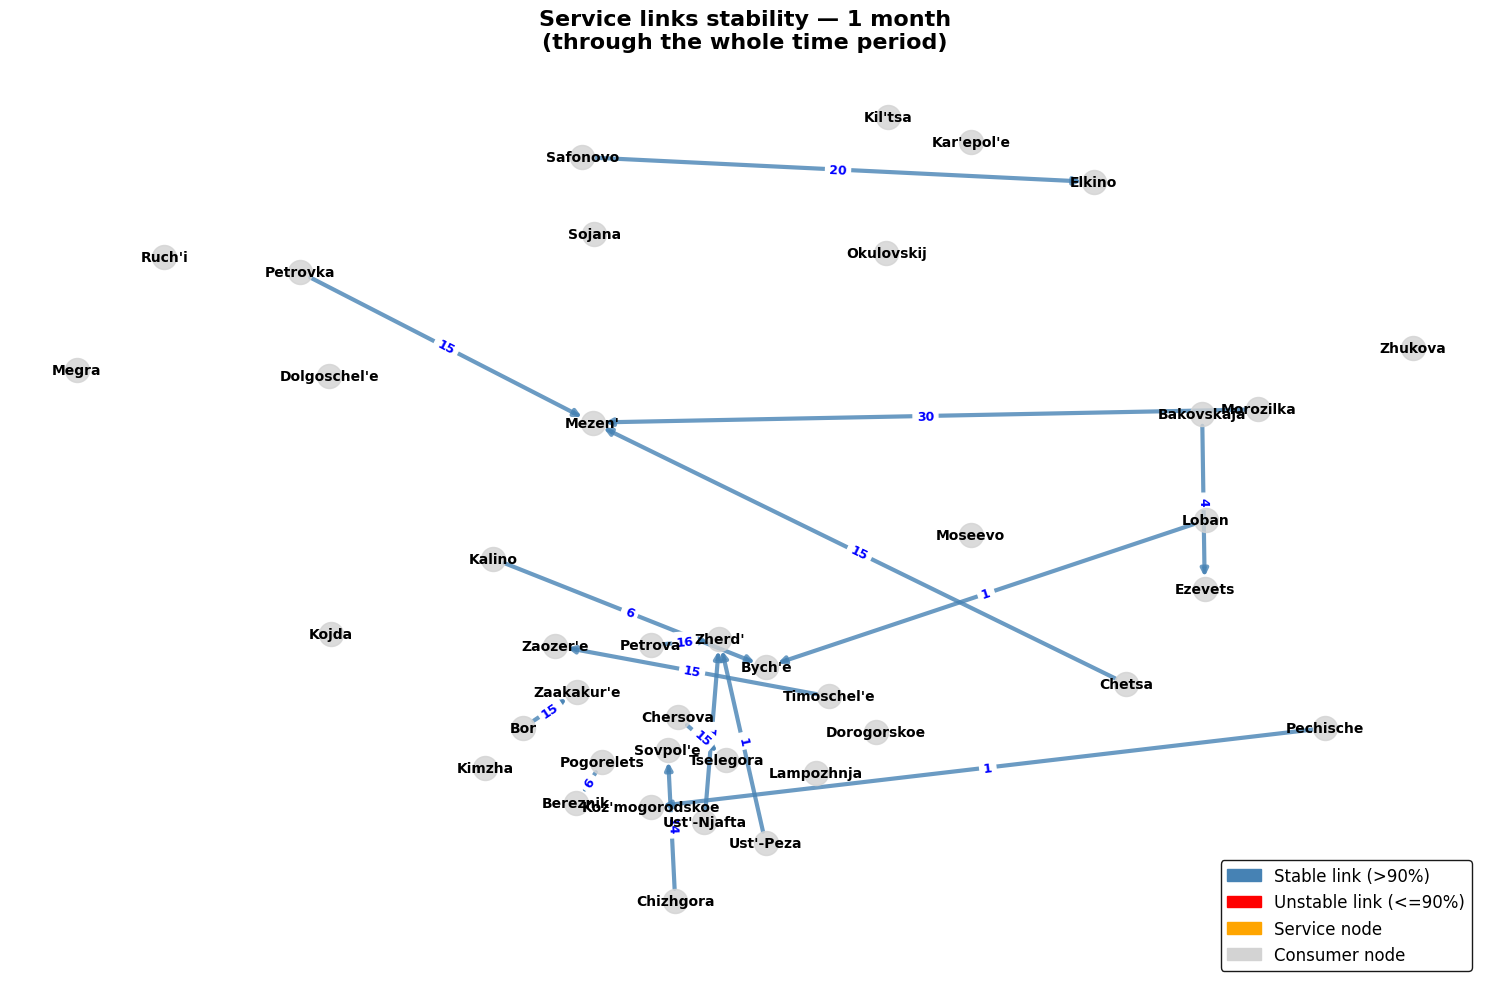


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


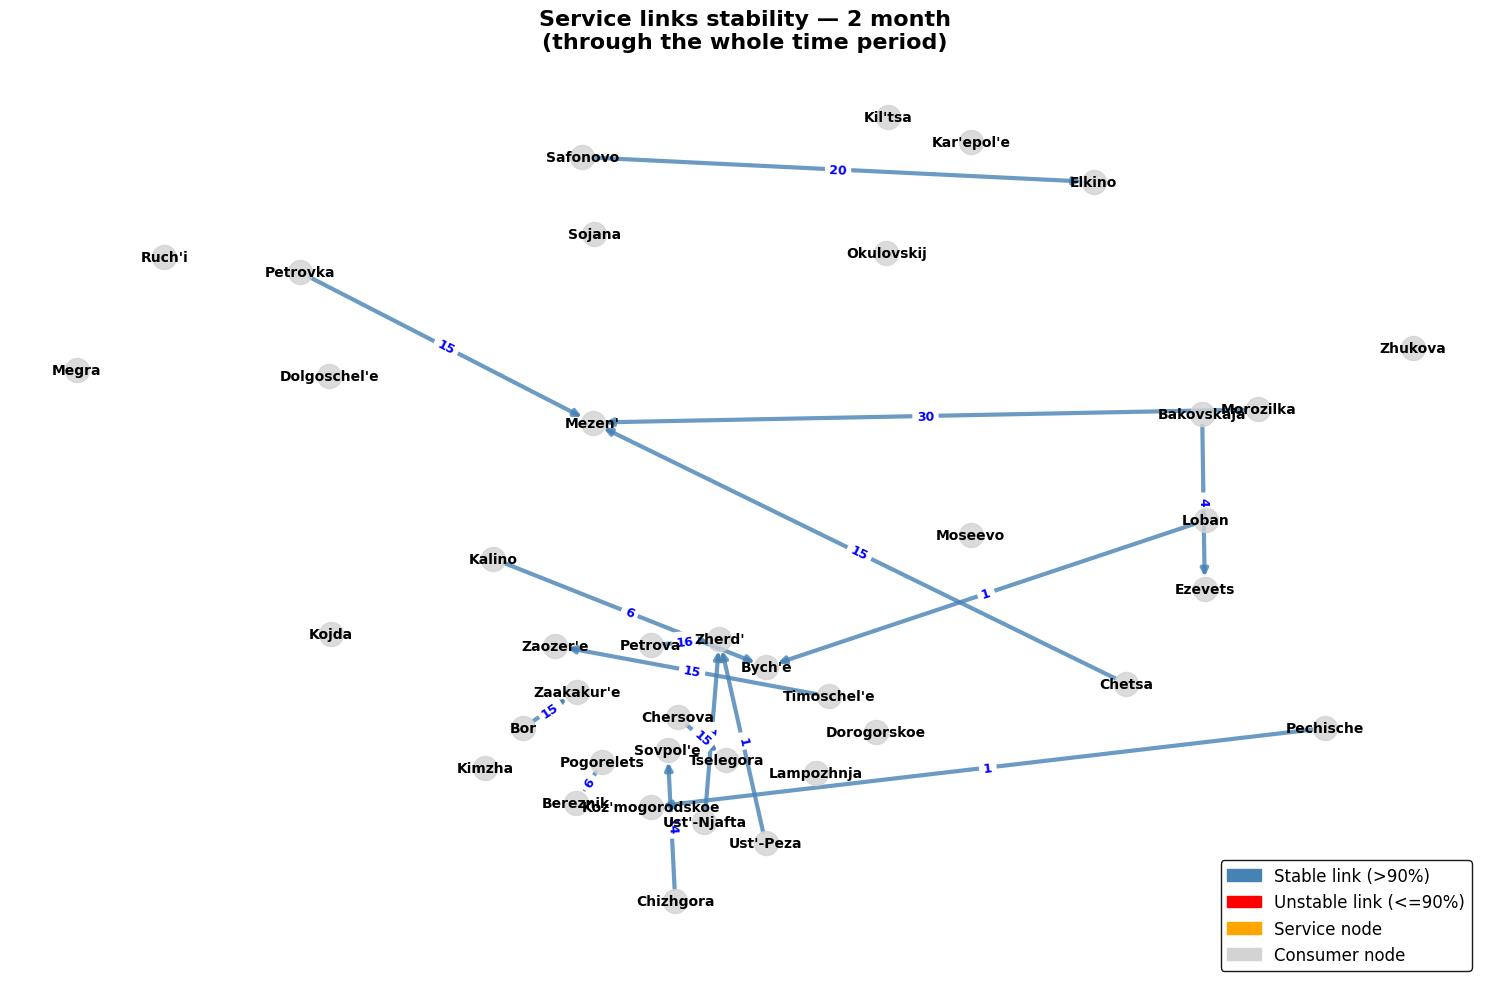


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


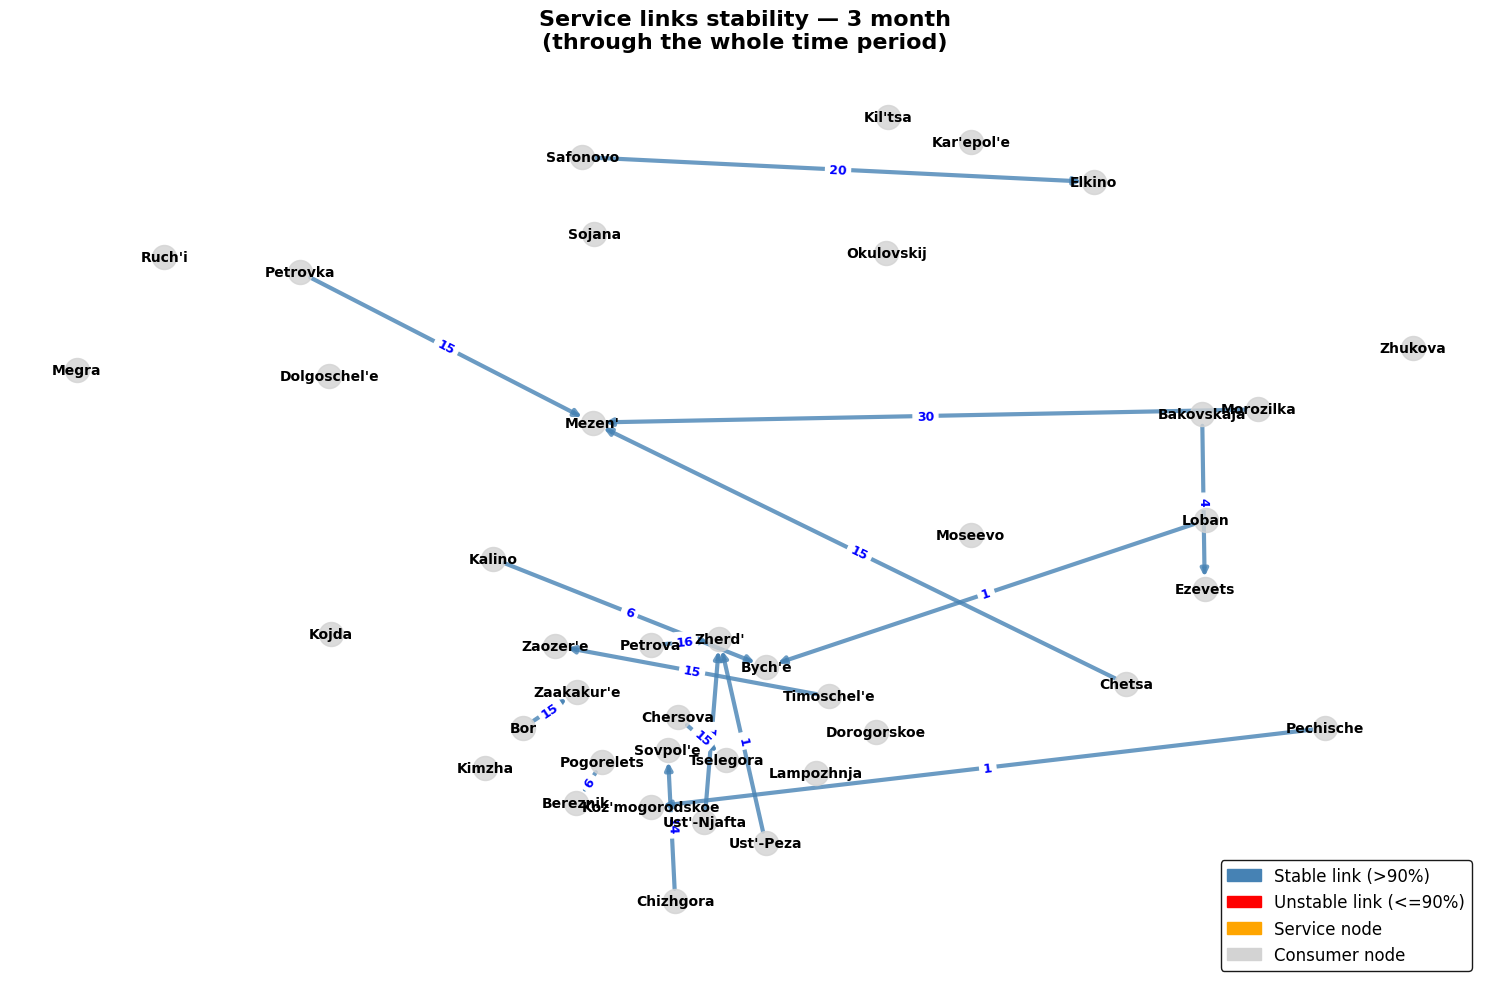


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


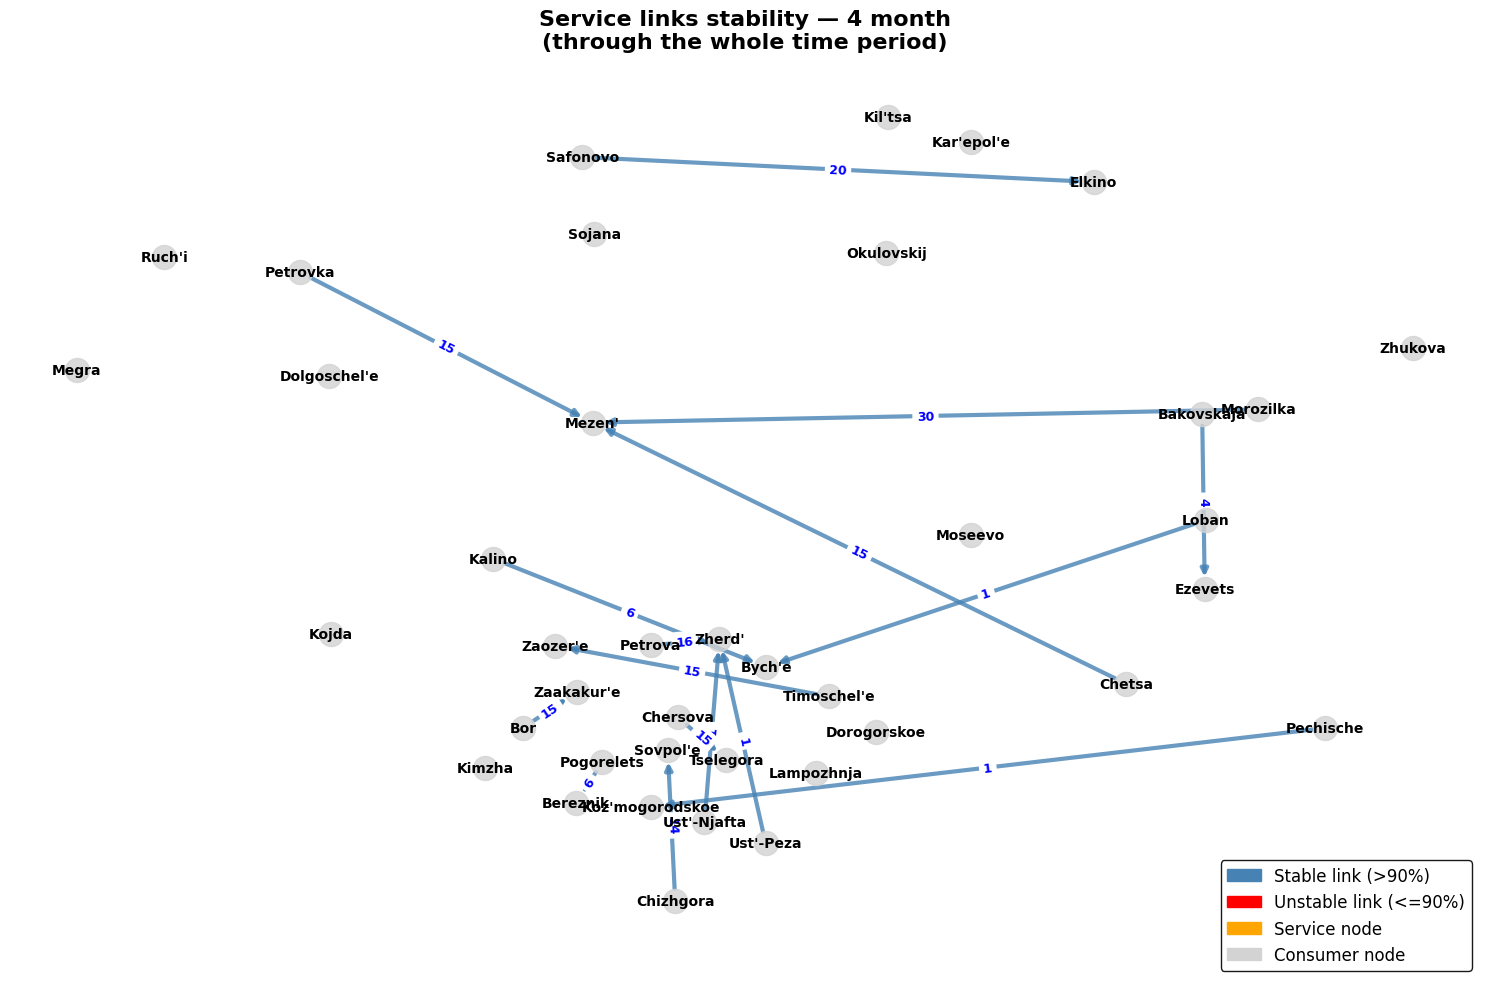


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


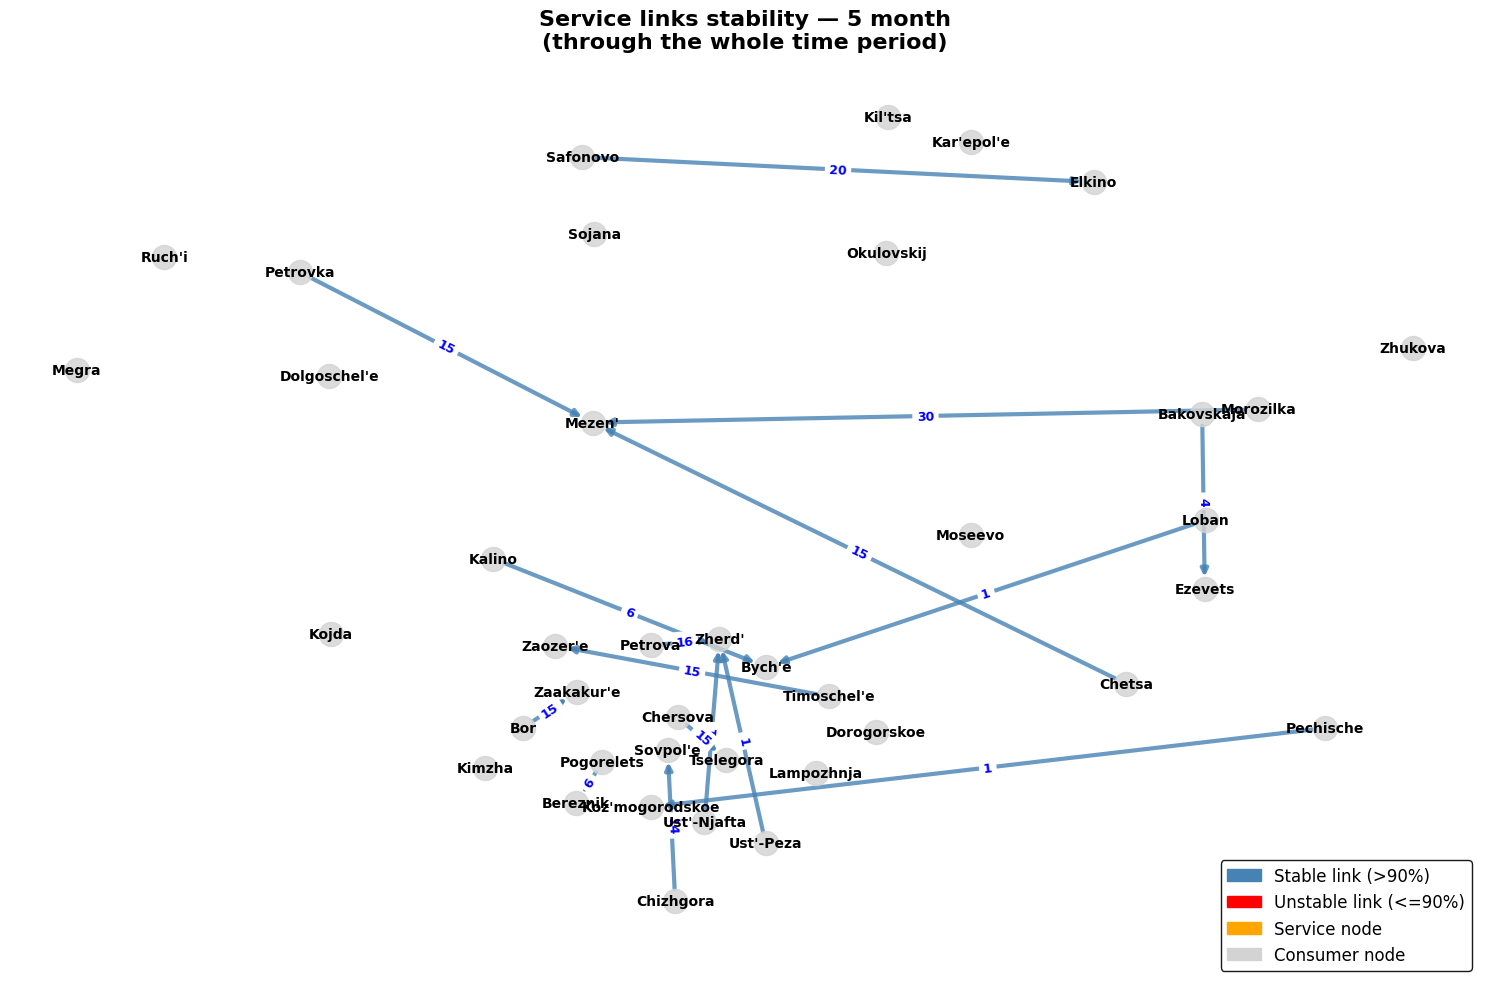


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


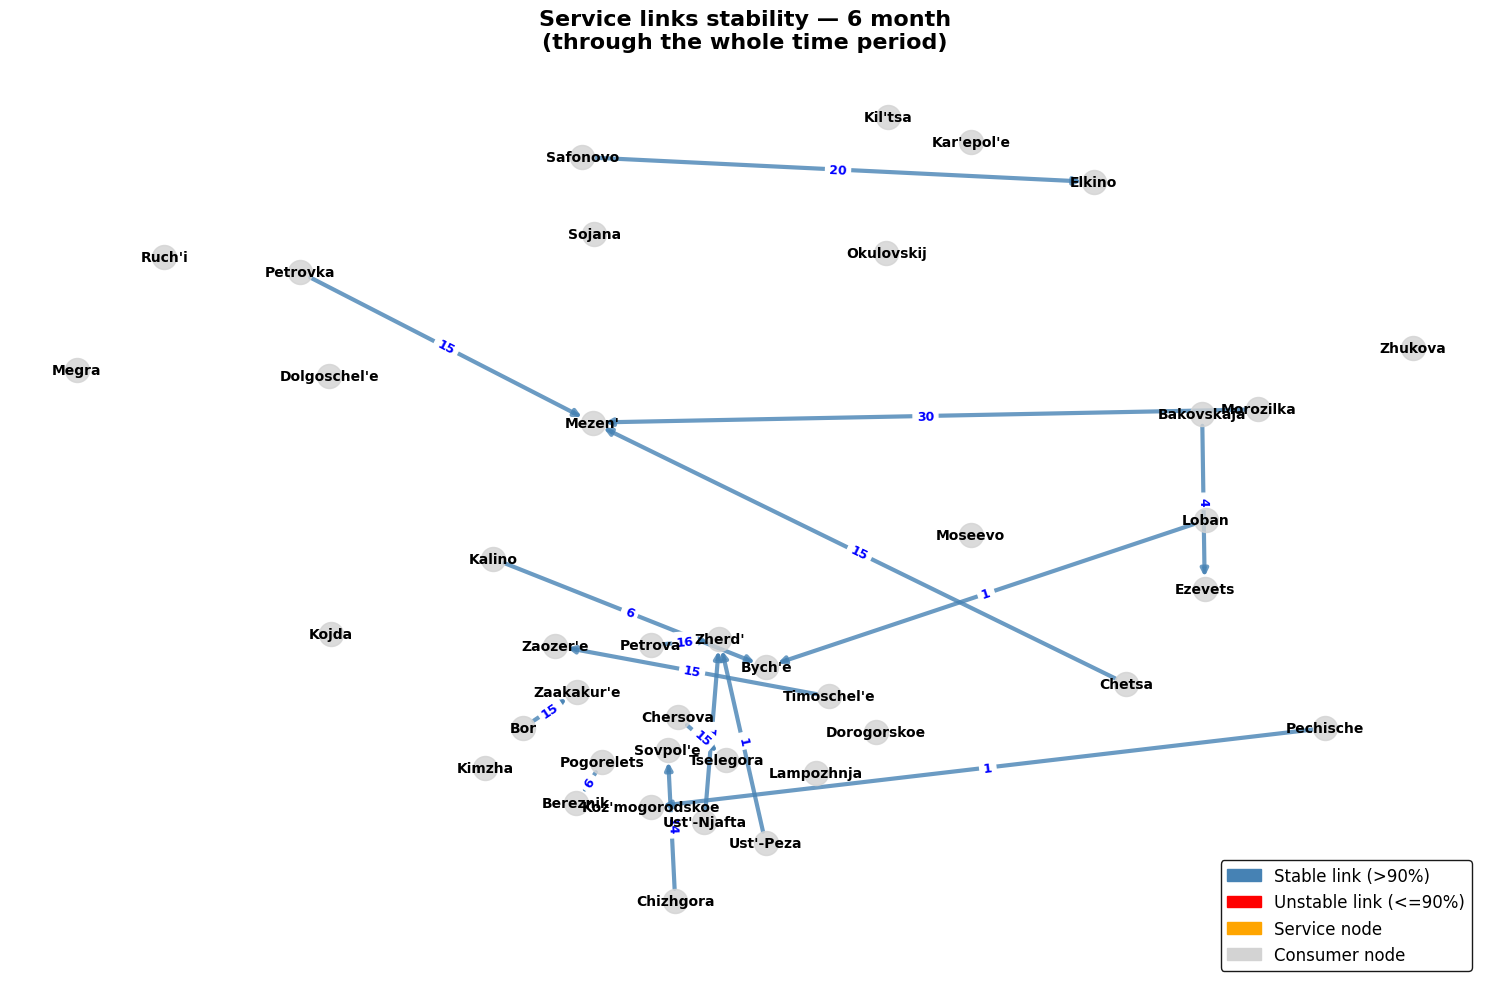


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


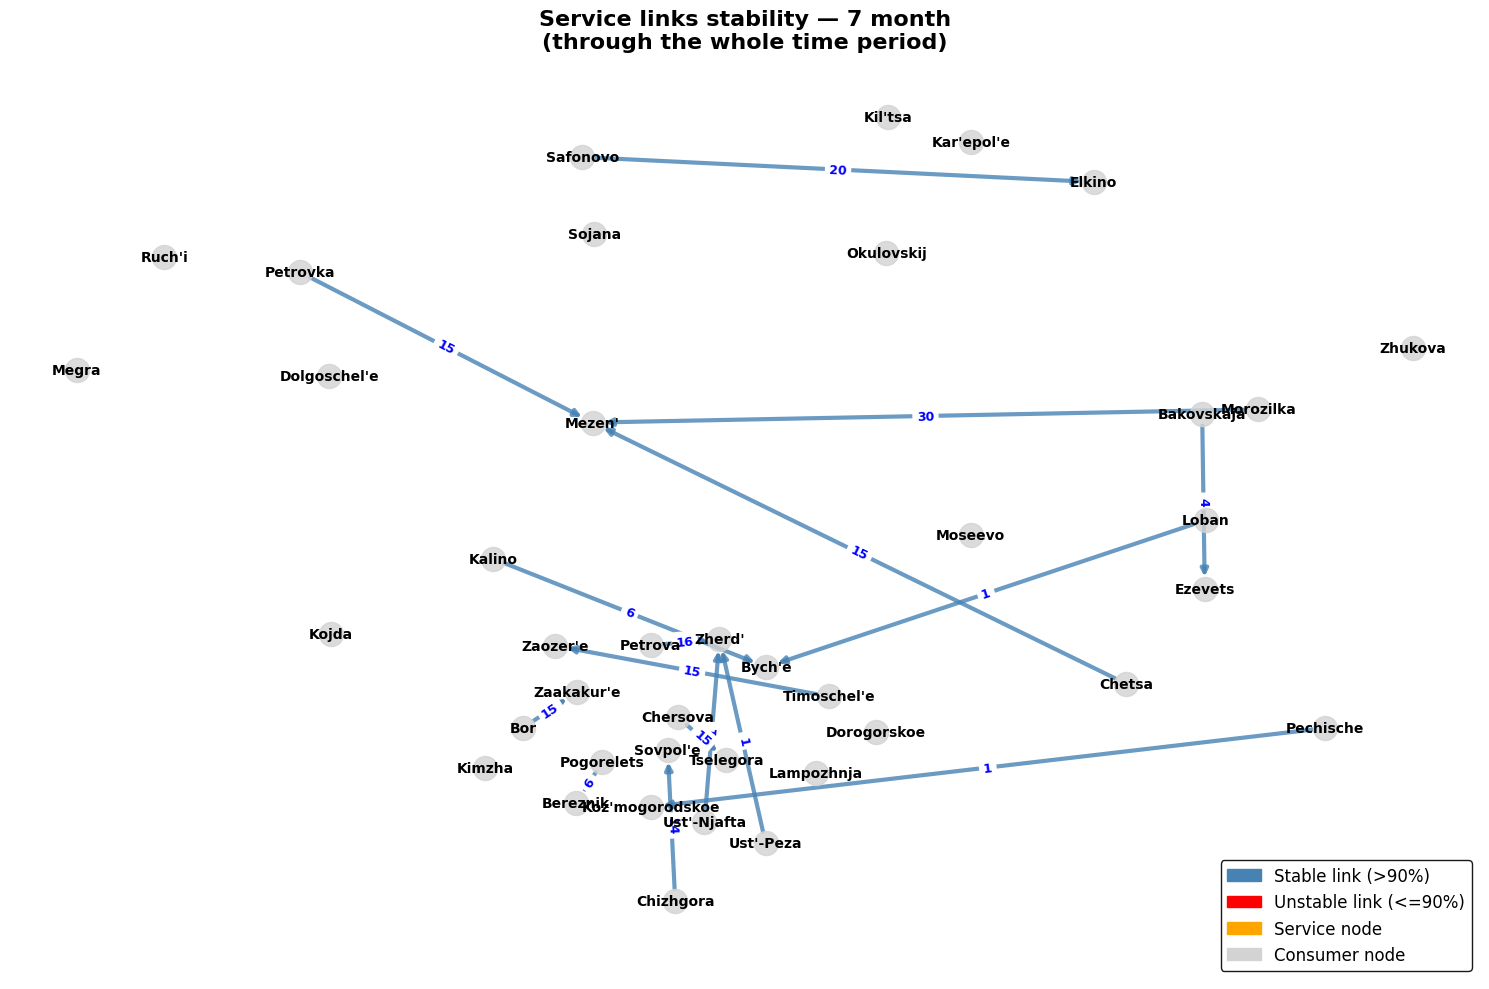


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


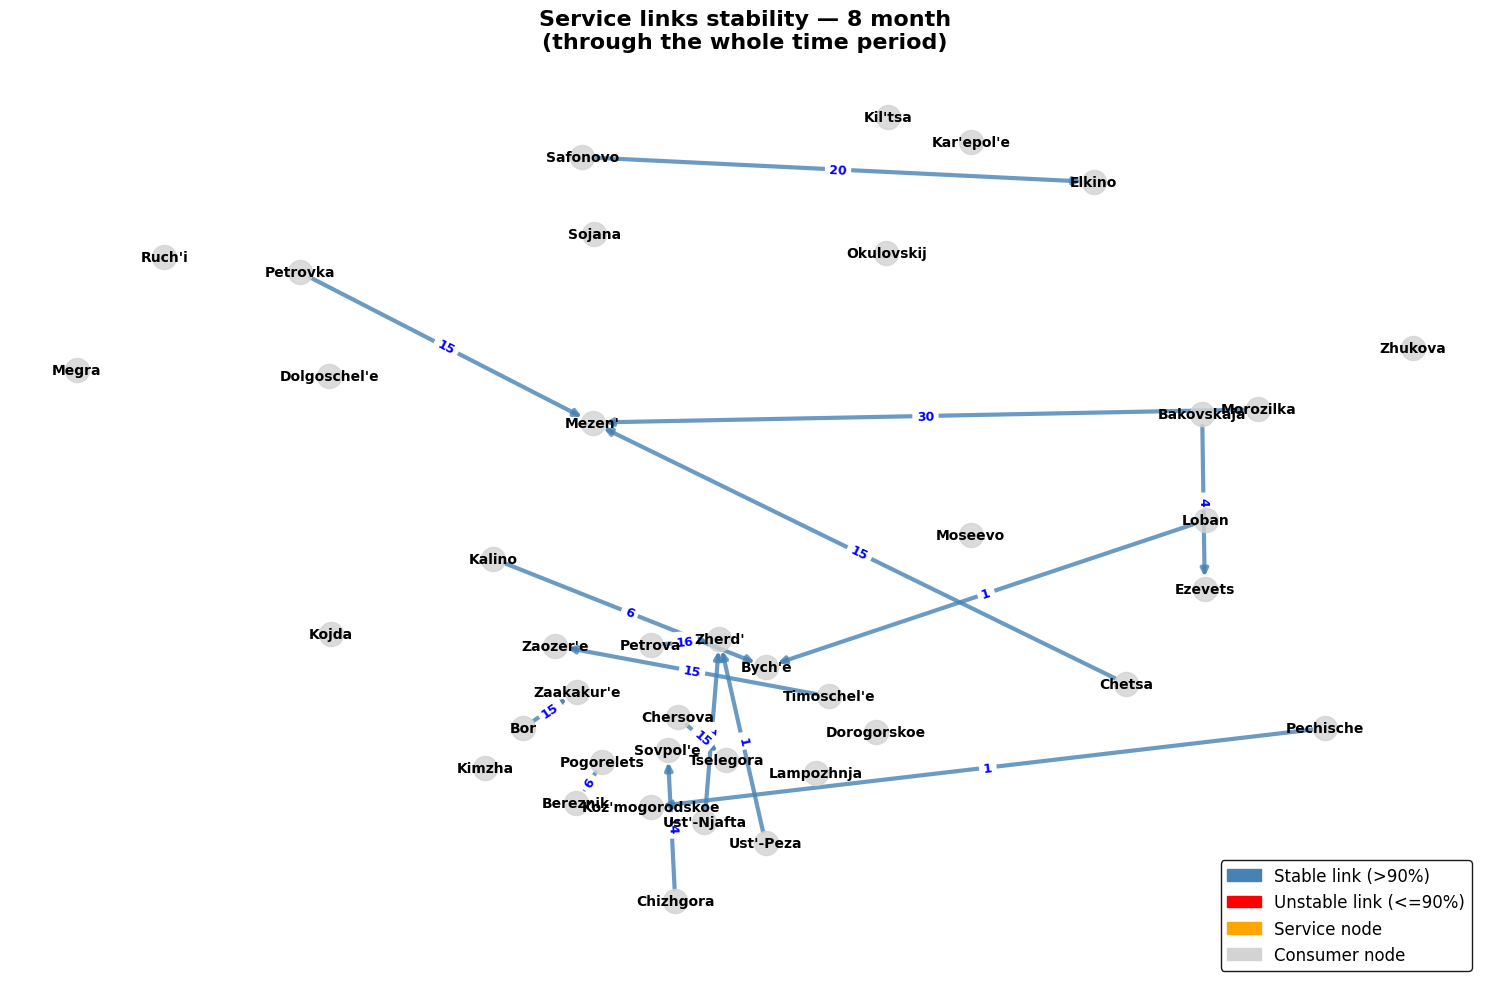


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


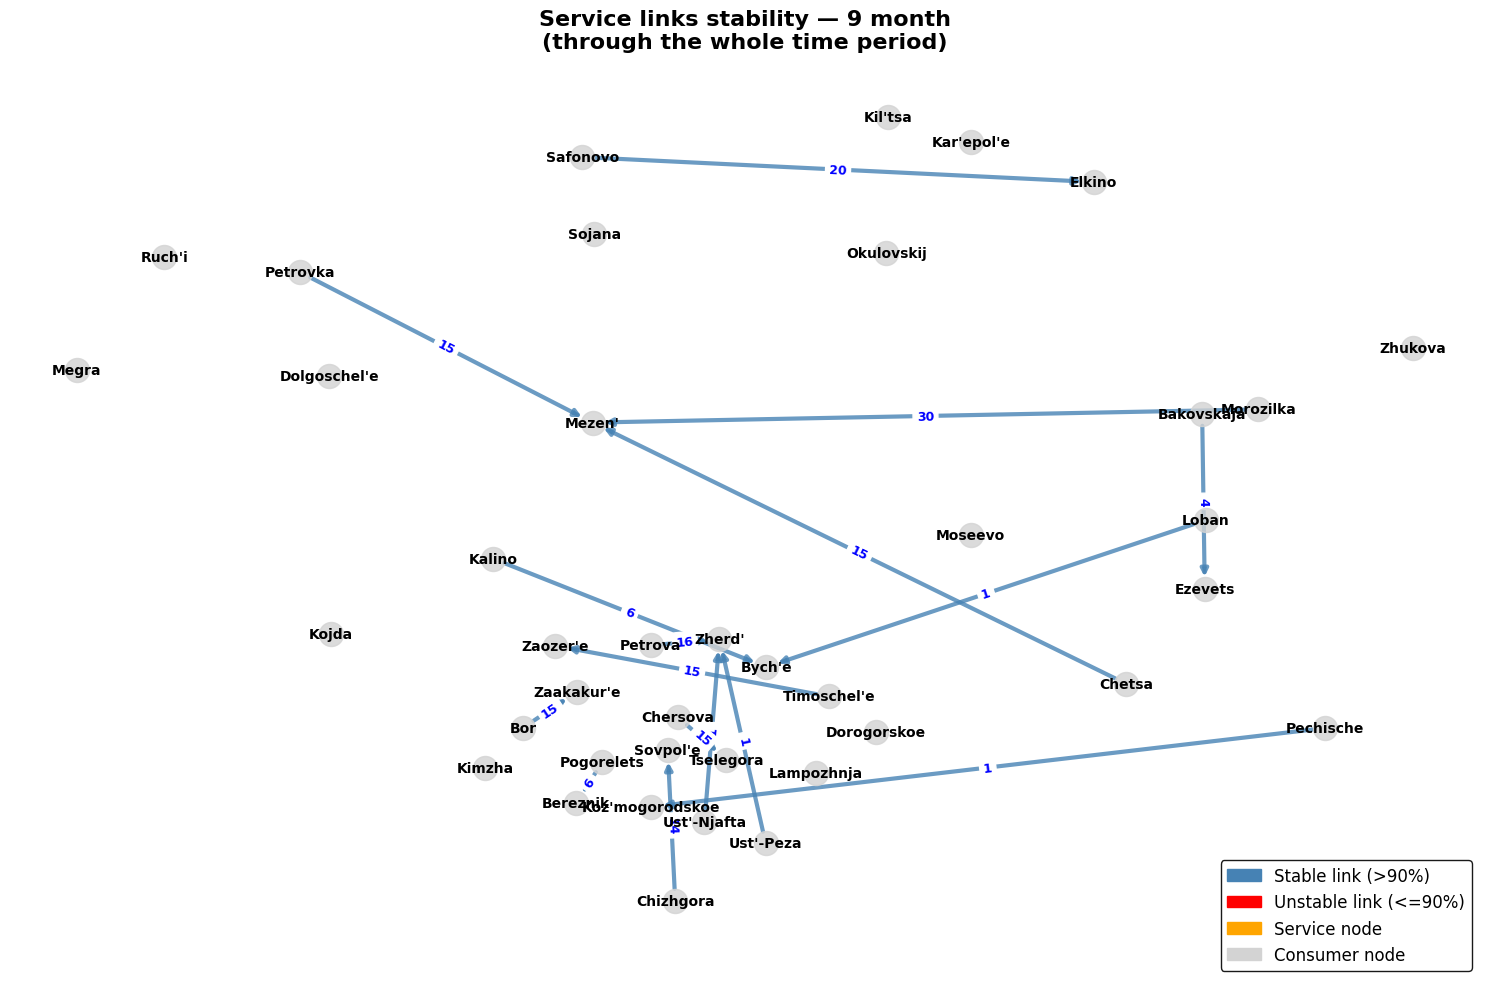


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


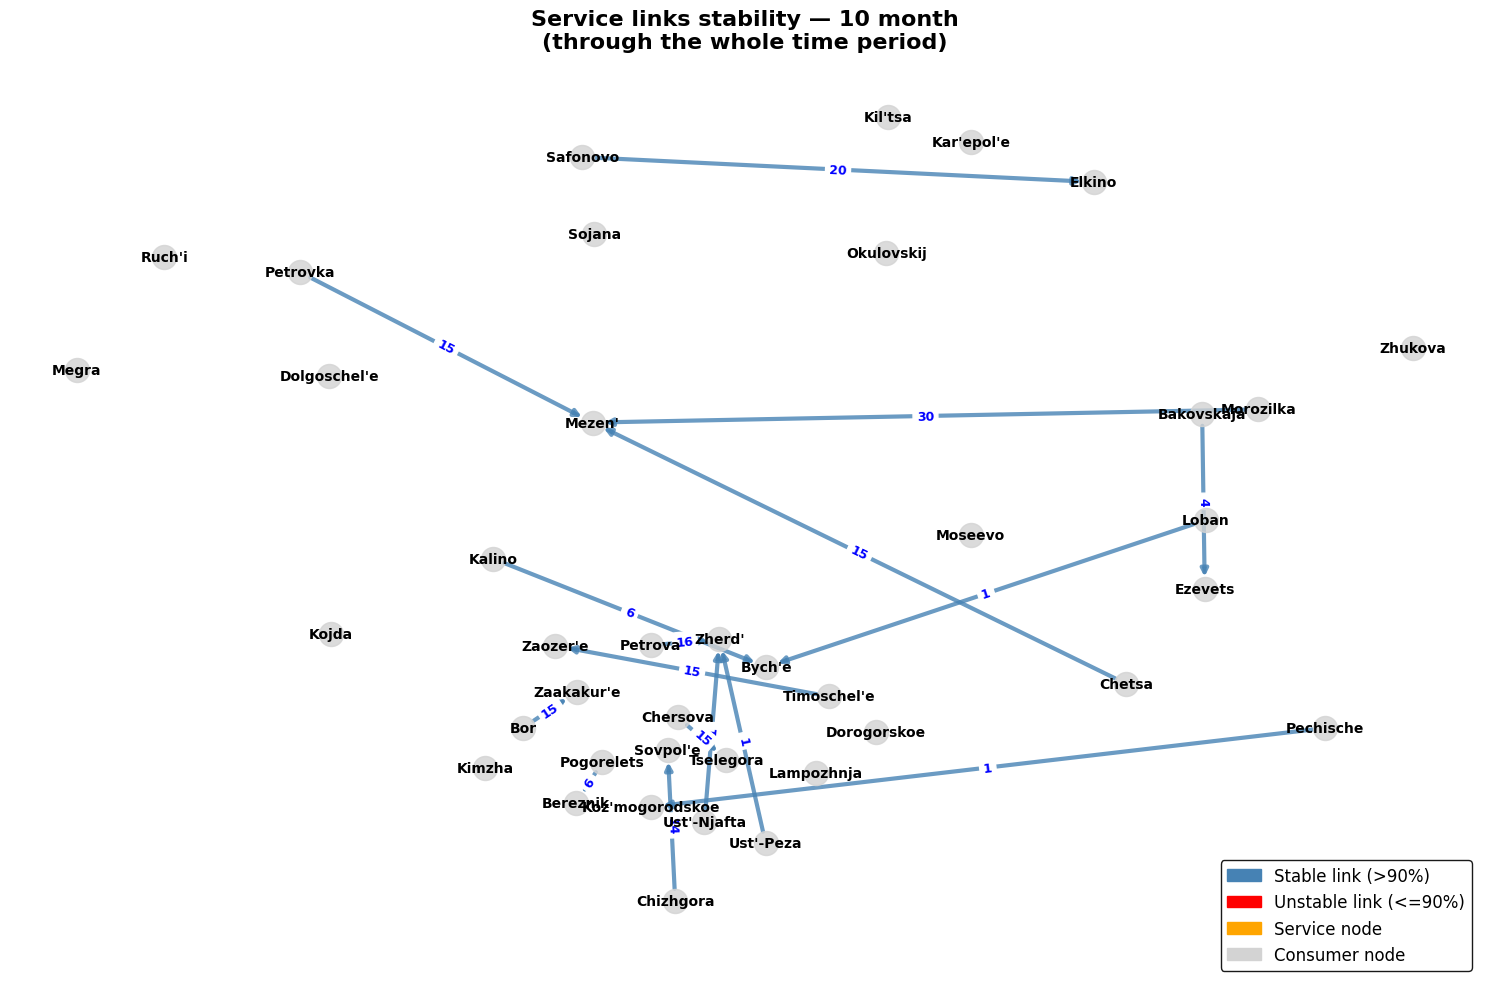


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


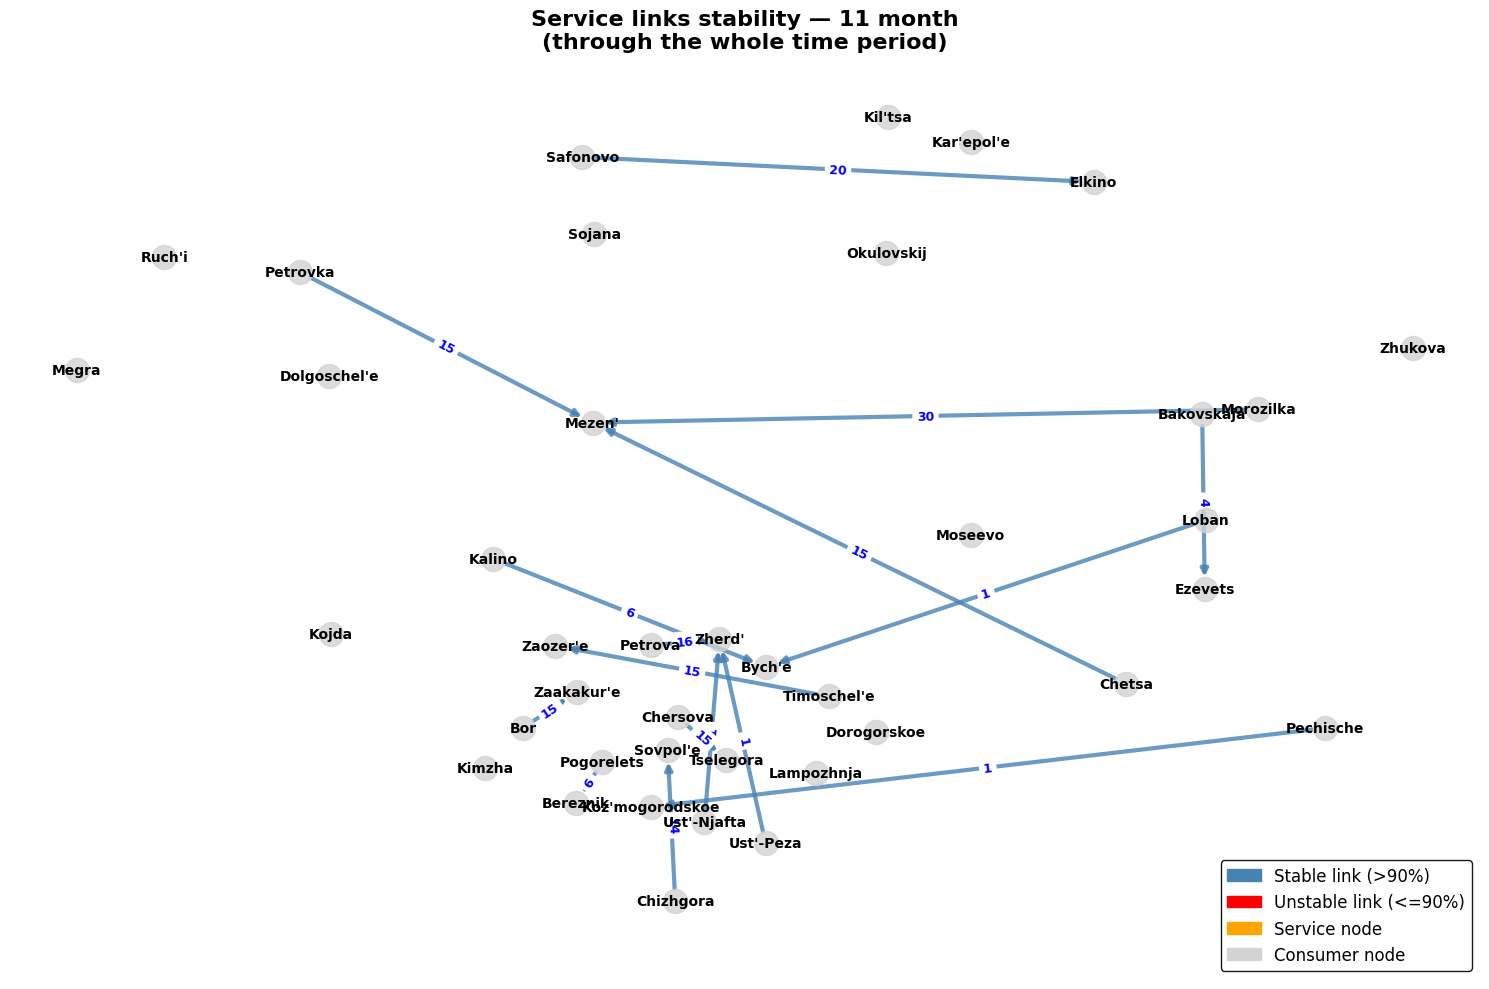


Service Links Summary:
- Total service connections: 16
- Stable connections: 16 (100.0%)
- Unstable connections: 0 (0.0%)
- Service providers: 0
- Consumer communities: 40


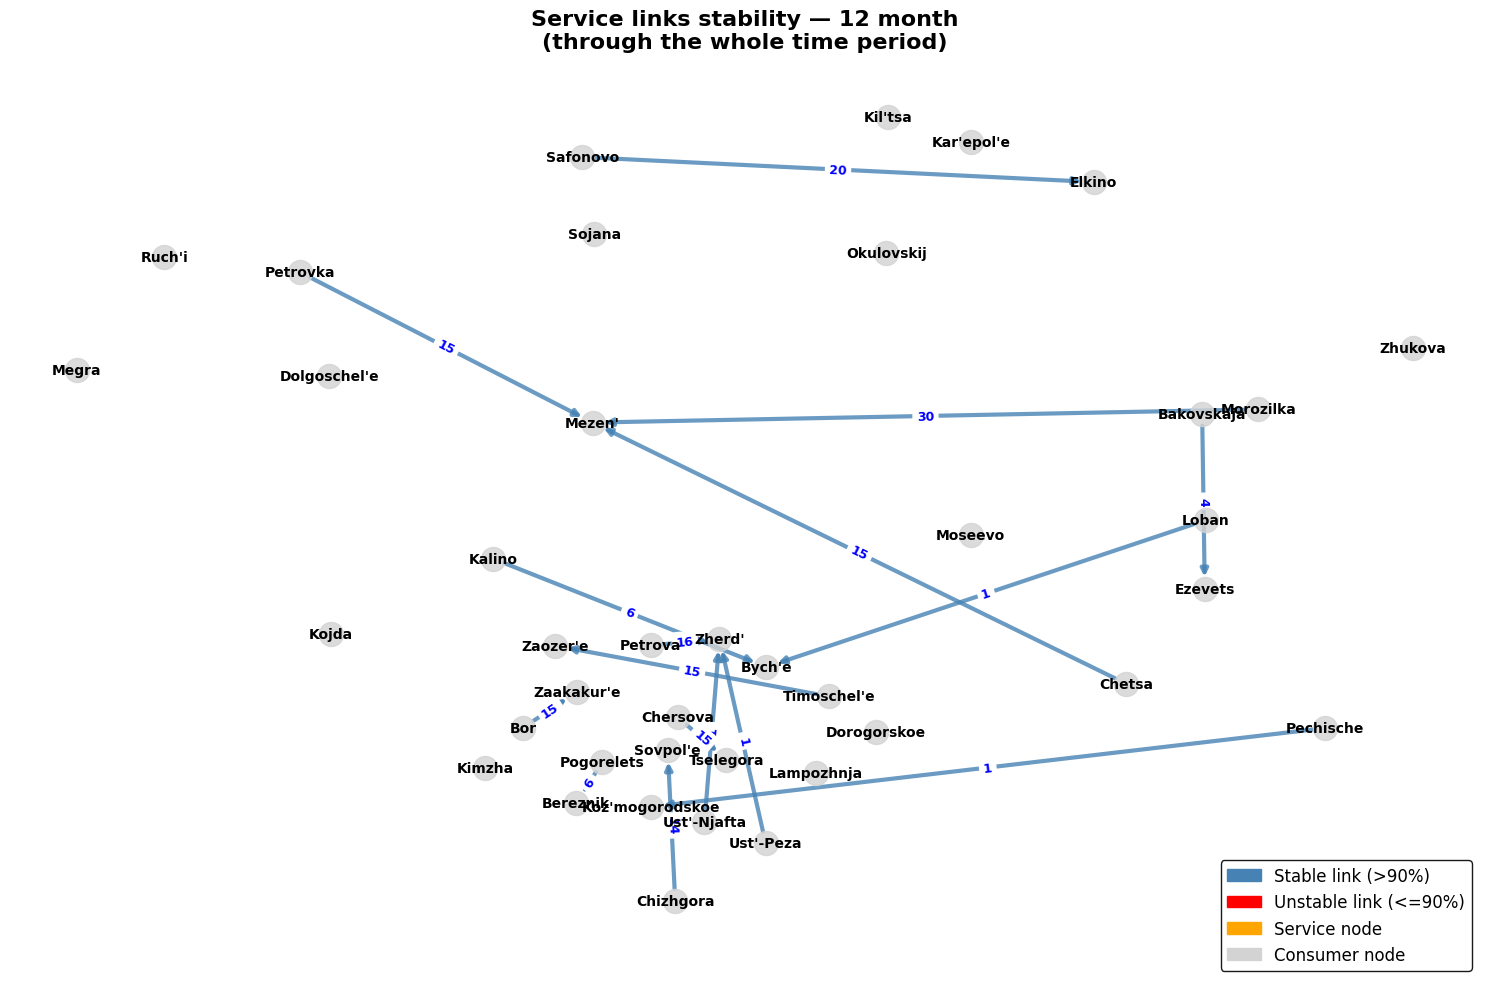

In [ ]:
for i in range(0, 12):
    analyze_service_month(
        net, month_idx=i, figsize=(15, 10), stability_threshold=0.9
    )  # June analysis with custom figsize
# analyze_service_month(net, month_idx=5, figsize=(8, 6))  # June analysis with smaller figsize


In [ ]:
1 / 0


ZeroDivisionError: division by zero

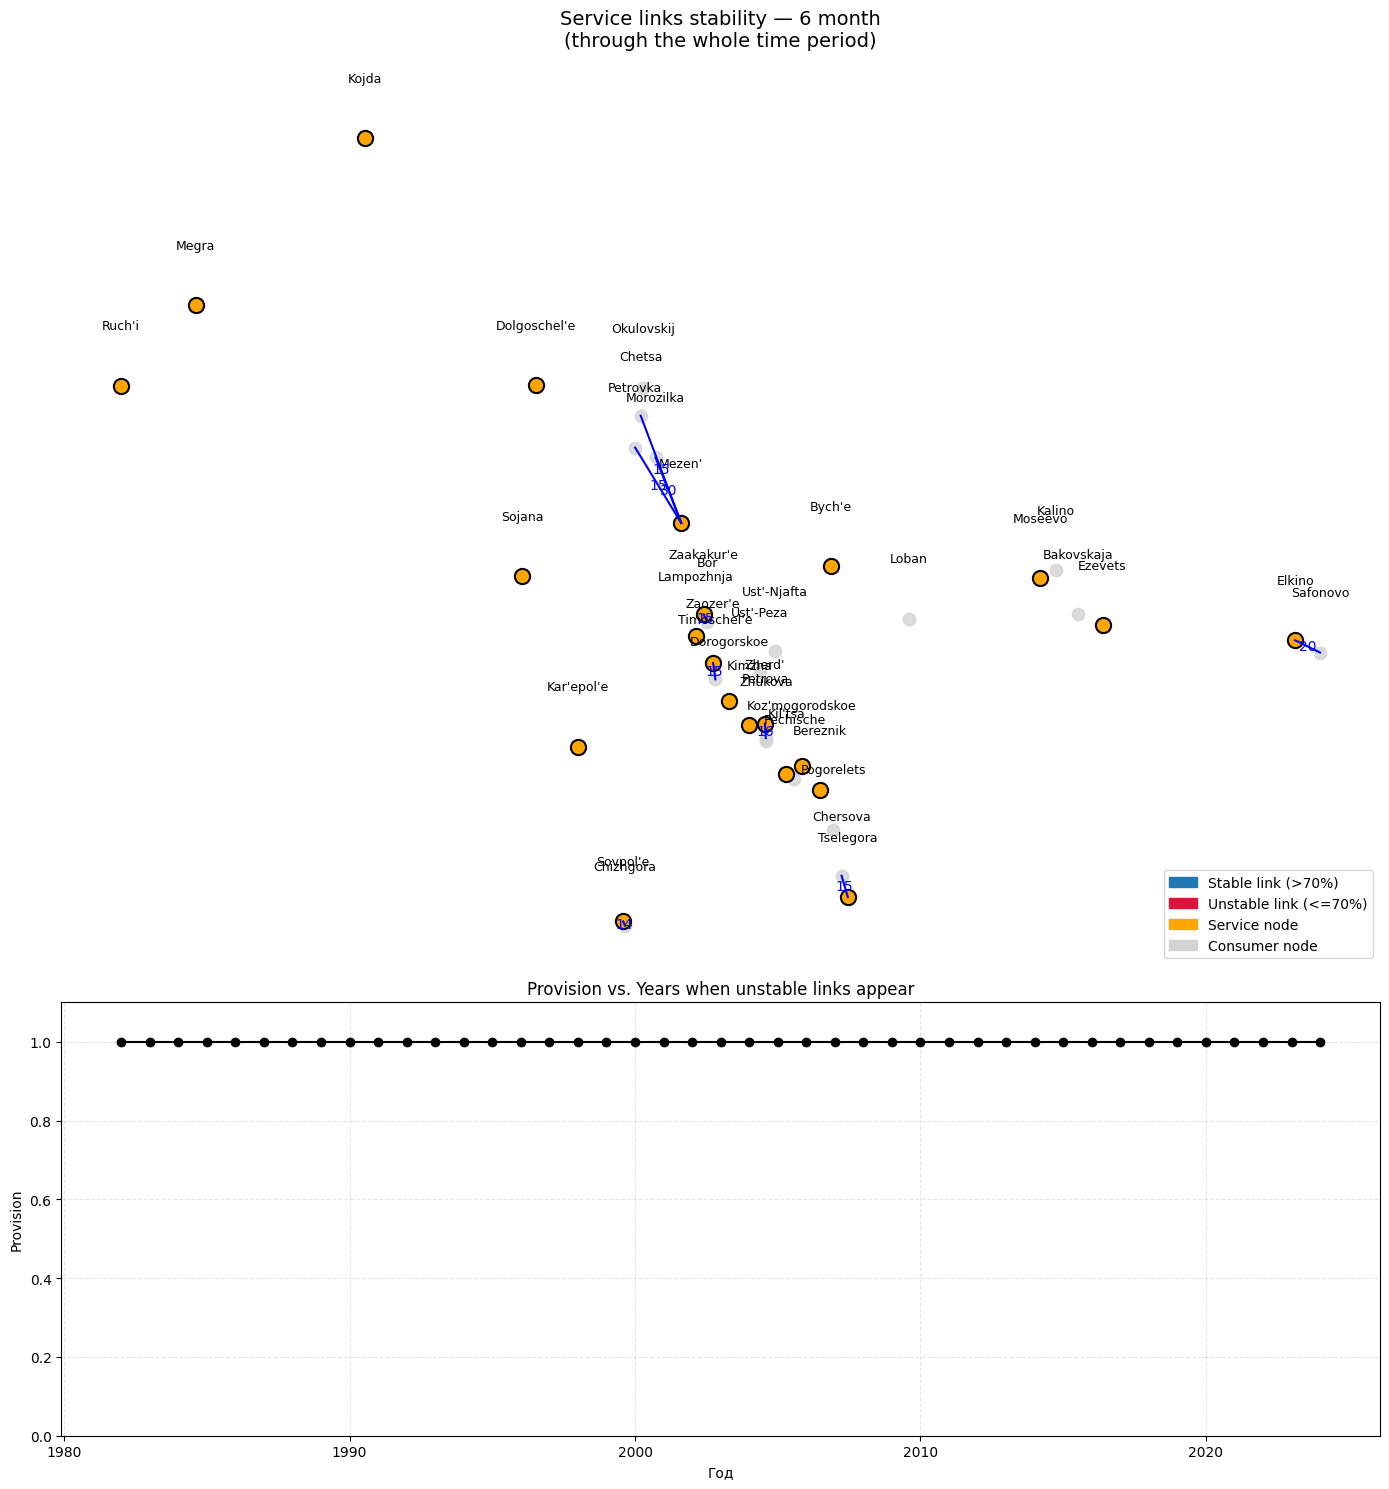

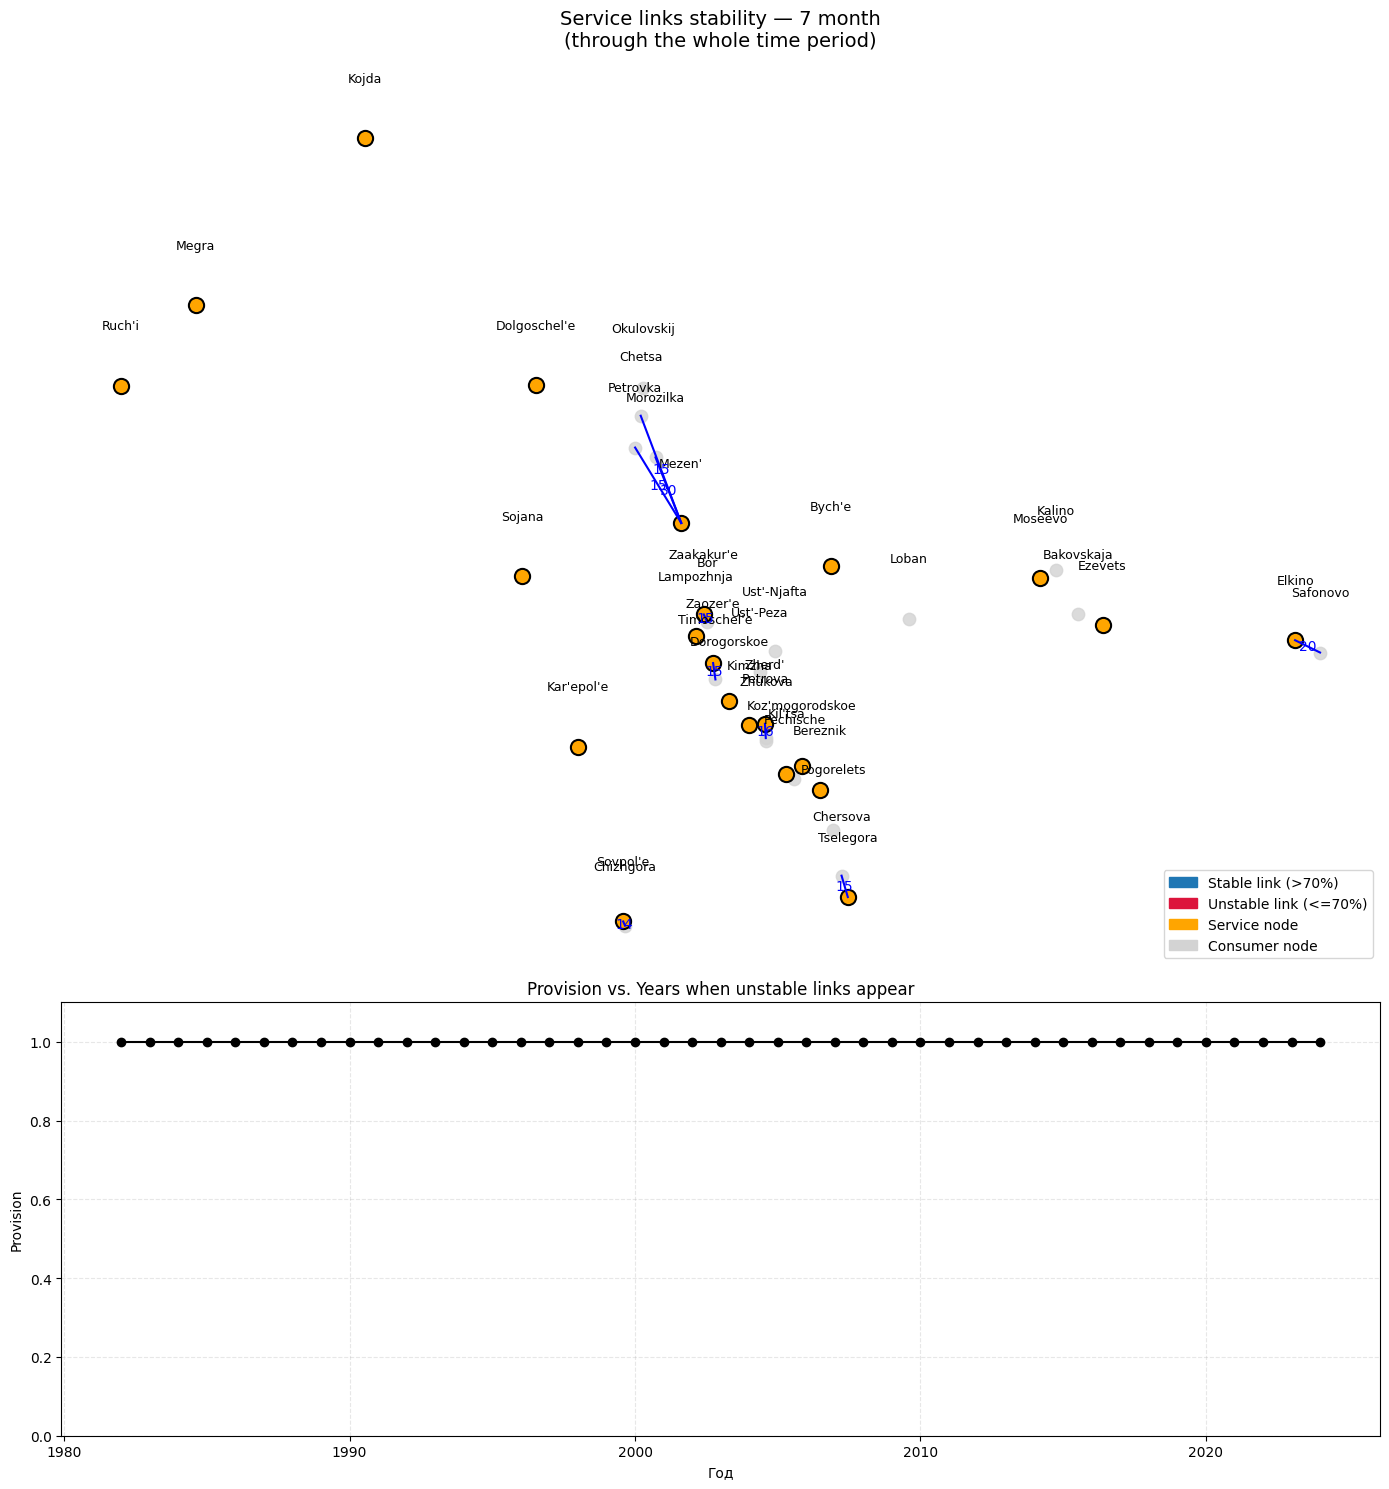

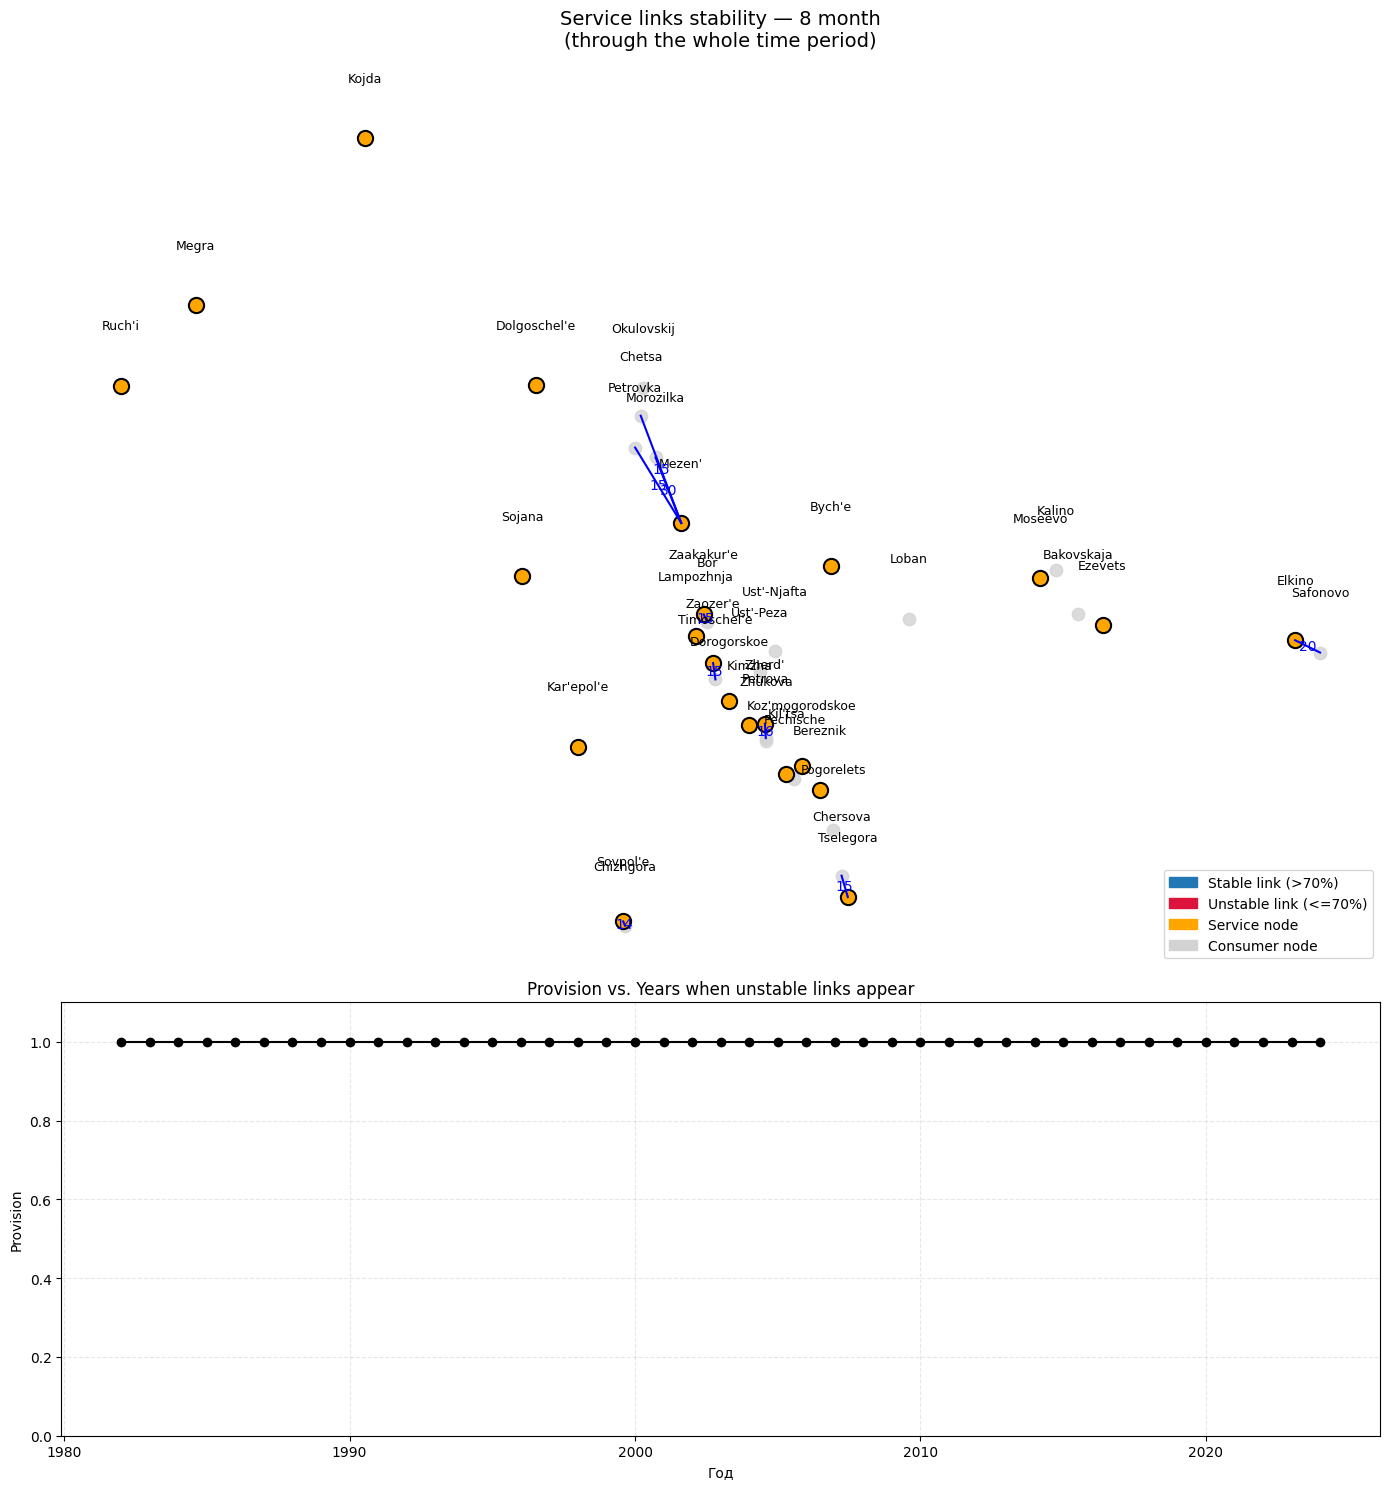

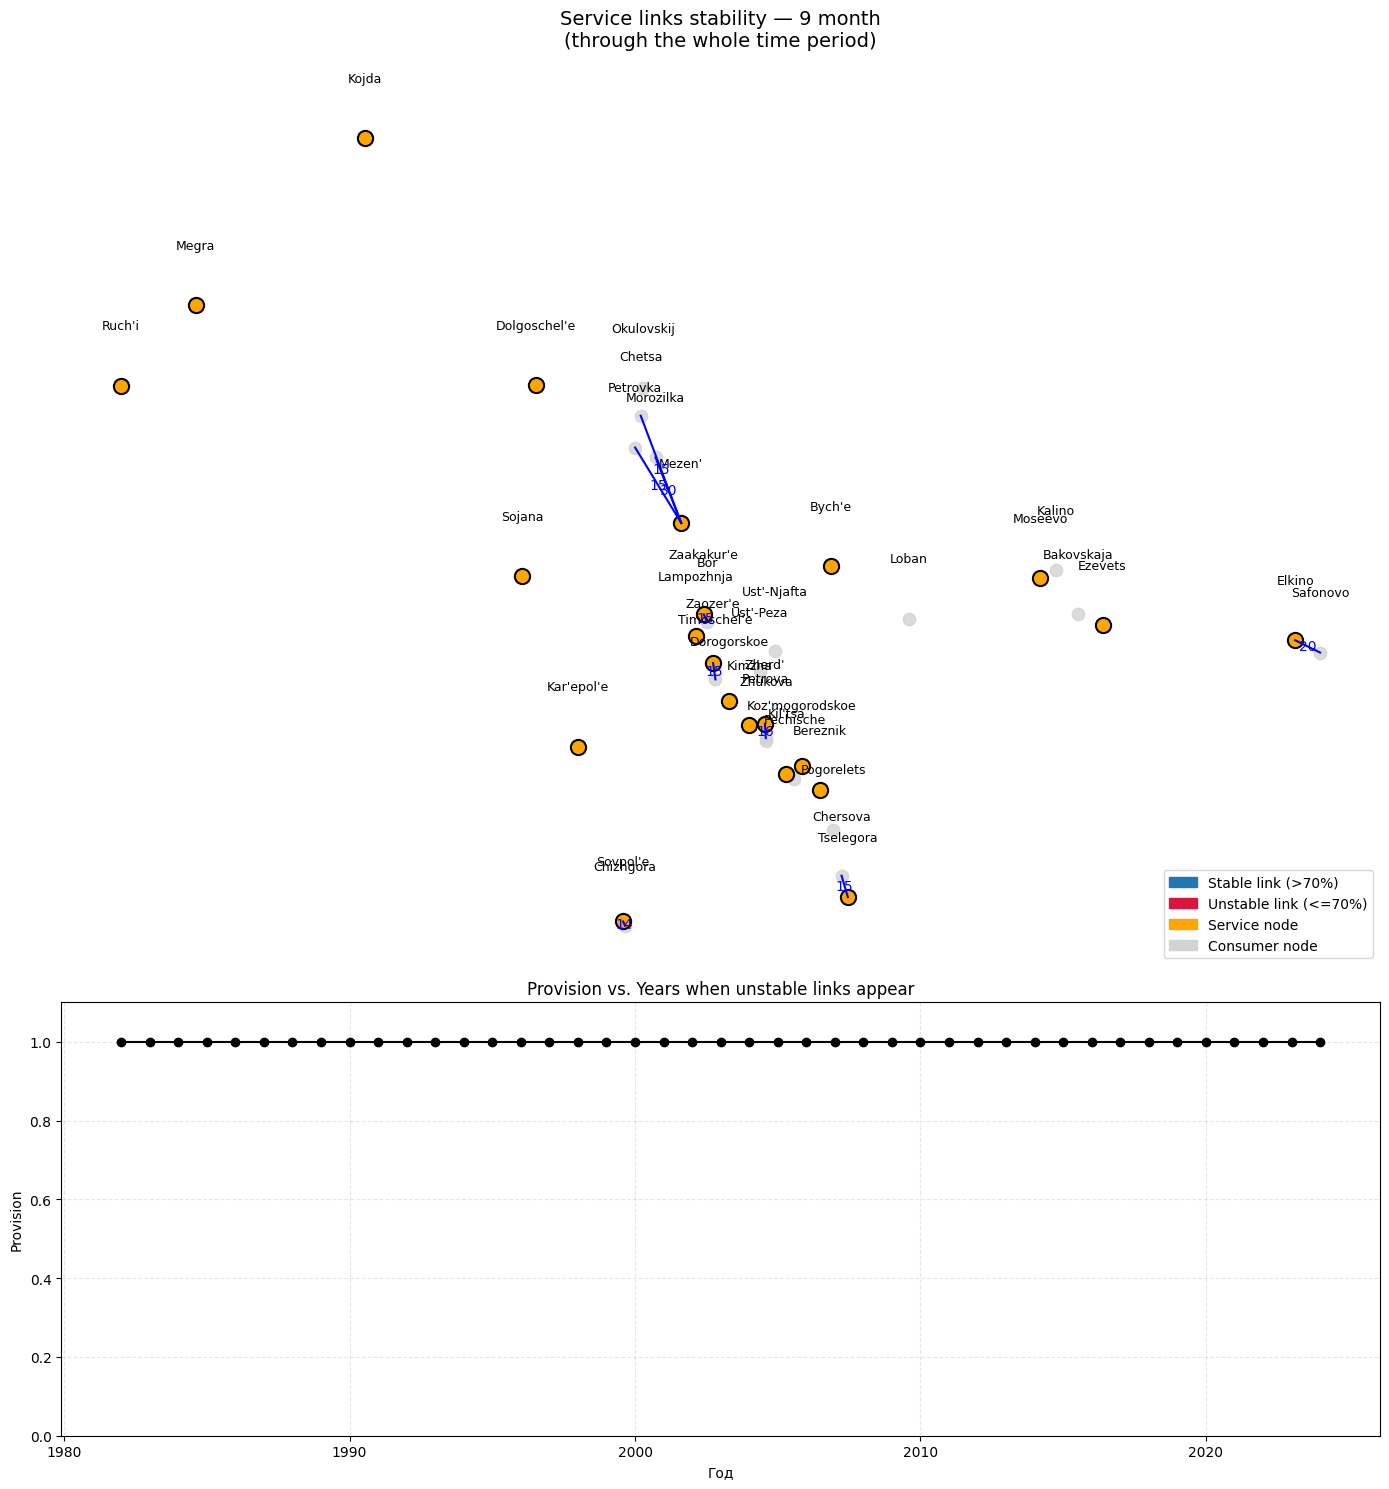

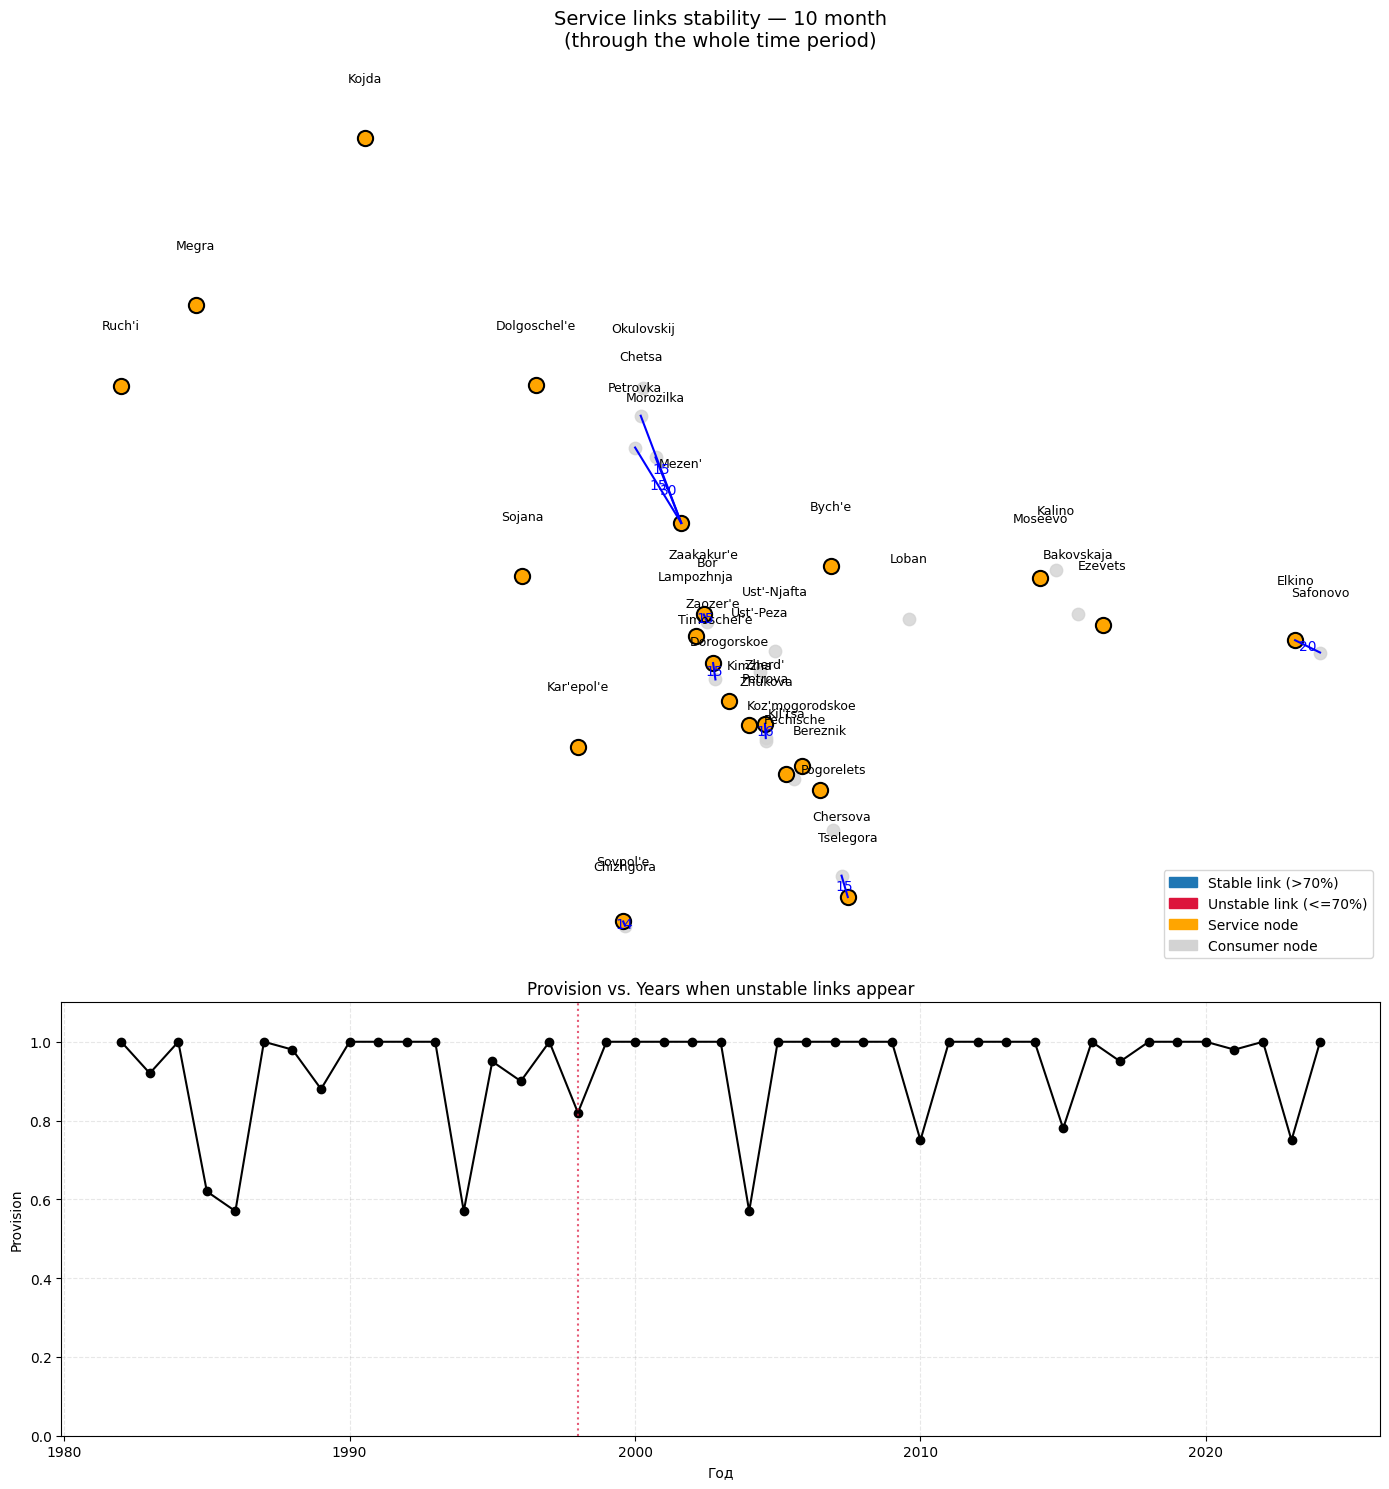

In [ ]:
for m in range(5, 10):
    rare_links, provision = edge_stability_over_years(
        net, month_idx=m, freq=0.7, figsize=(14, 15)
    )


ex:  'Hantajskoe Ozero'
Levinskie Peski Dudinka
{'weight': 17.0, 'label': 'Water transport', 'temperature': np.int64(5), 'transport_probability': np.float64(0.99632), 'is_service_route': True, 'service_flows': np.int64(14)}
{'weight': 17.0, 'label': 'Water transport', 'temperature': np.int64(6), 'transport_probability': np.float64(0.99834), 'is_service_route': True, 'service_flows': np.int64(14)}


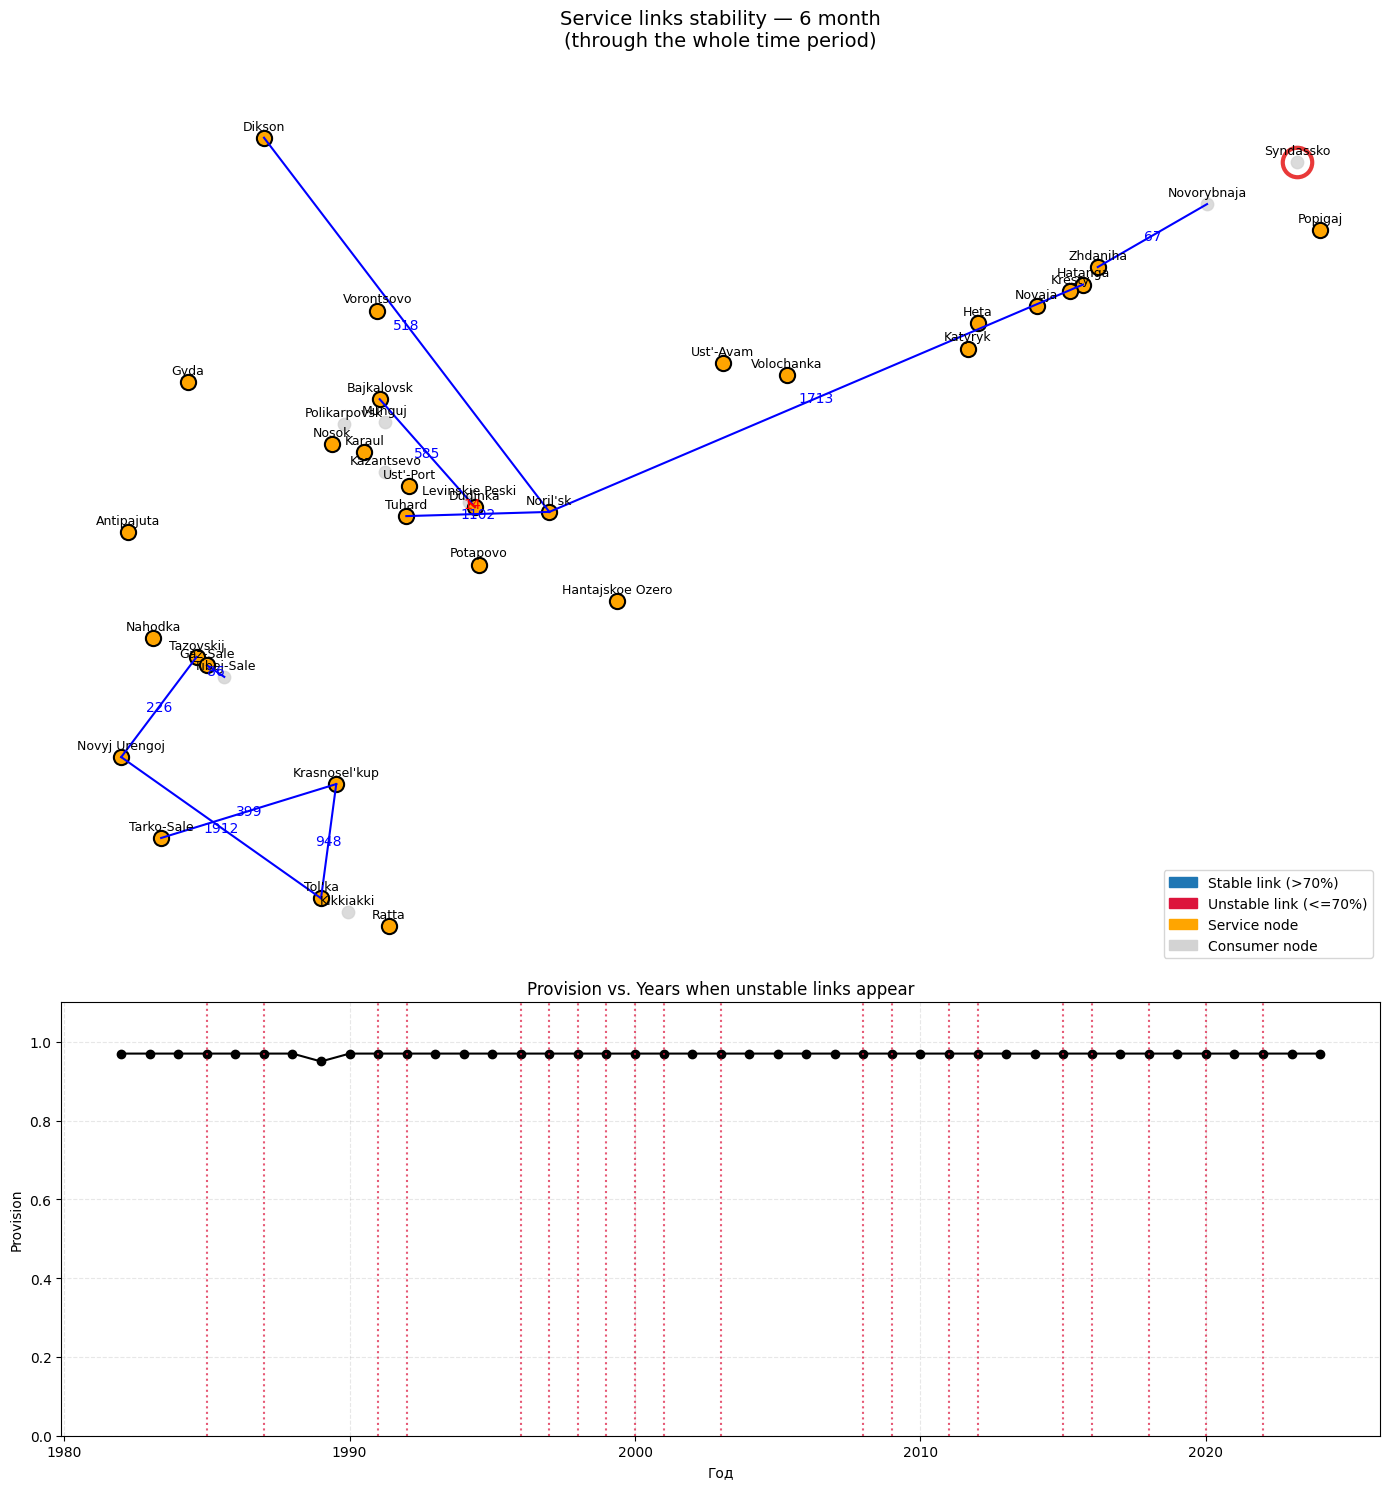

Syndassko Hatanga
{'weight': 1920.0, 'label': 'Winter road', 'temperature': np.int64(8), 'transport_probability': np.float64(0.83202), 'assignment': np.int64(60), 'path': ['Syndassko', 'Hatanga'], 'is_service_flow': True, 'is_within': False, 'is_service_route': True, 'service_flows': np.int64(60)}
{'weight': 1920.0, 'label': 'Winter road', 'temperature': np.int64(5), 'transport_probability': np.float64(0.98201), 'assignment': np.int64(60), 'path': ['Syndassko', 'Hatanga'], 'is_service_flow': True, 'is_within': False, 'is_service_route': True, 'service_flows': np.int64(60)}


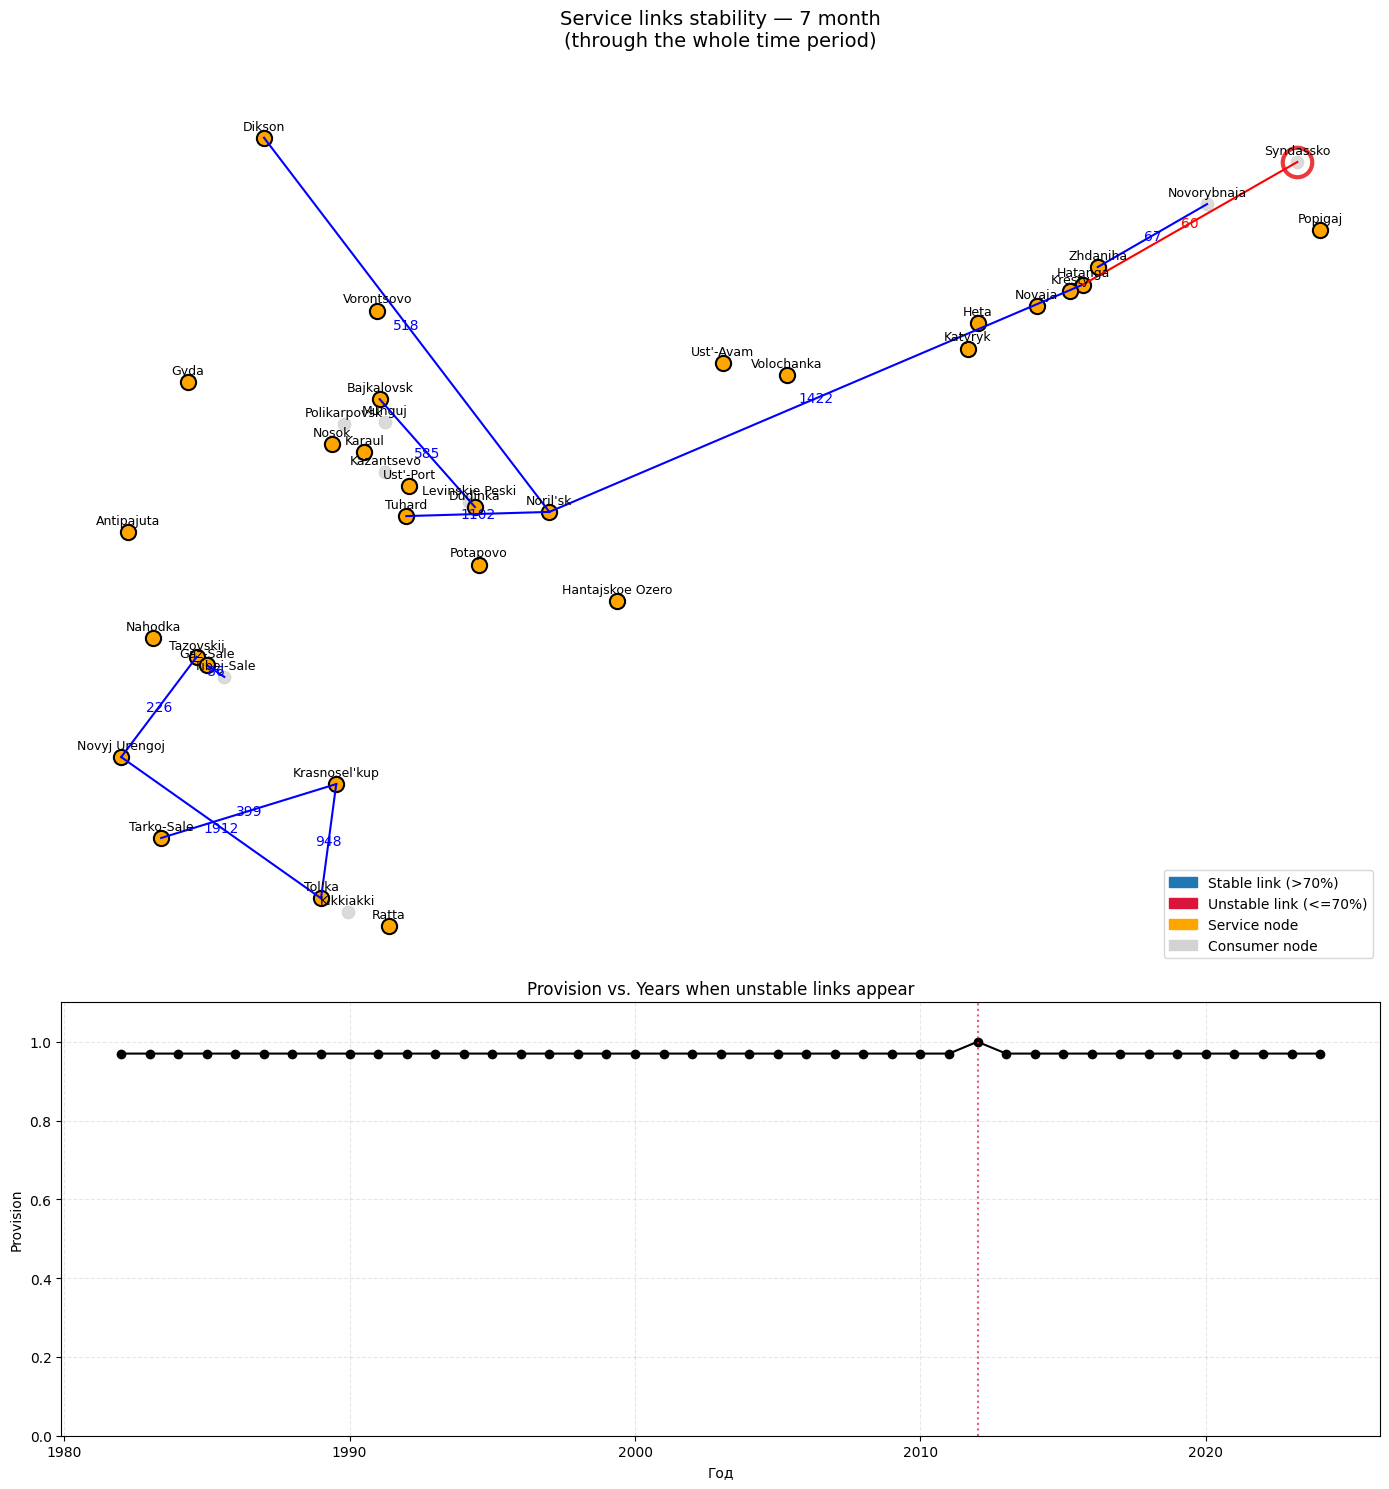

ex:  'Kresty'
Syndassko Hatanga
{'weight': 1920.0, 'label': 'Winter road', 'temperature': np.int64(8), 'transport_probability': np.float64(0.83202), 'assignment': np.int64(60), 'path': ['Syndassko', 'Hatanga'], 'is_service_flow': True, 'is_within': False, 'is_service_route': True, 'service_flows': np.int64(60)}
{'weight': 1920.0, 'label': 'Winter road', 'temperature': np.int64(5), 'transport_probability': np.float64(0.98201), 'assignment': np.int64(60), 'path': ['Syndassko', 'Hatanga'], 'is_service_flow': True, 'is_within': False, 'is_service_route': True, 'service_flows': np.int64(60)}


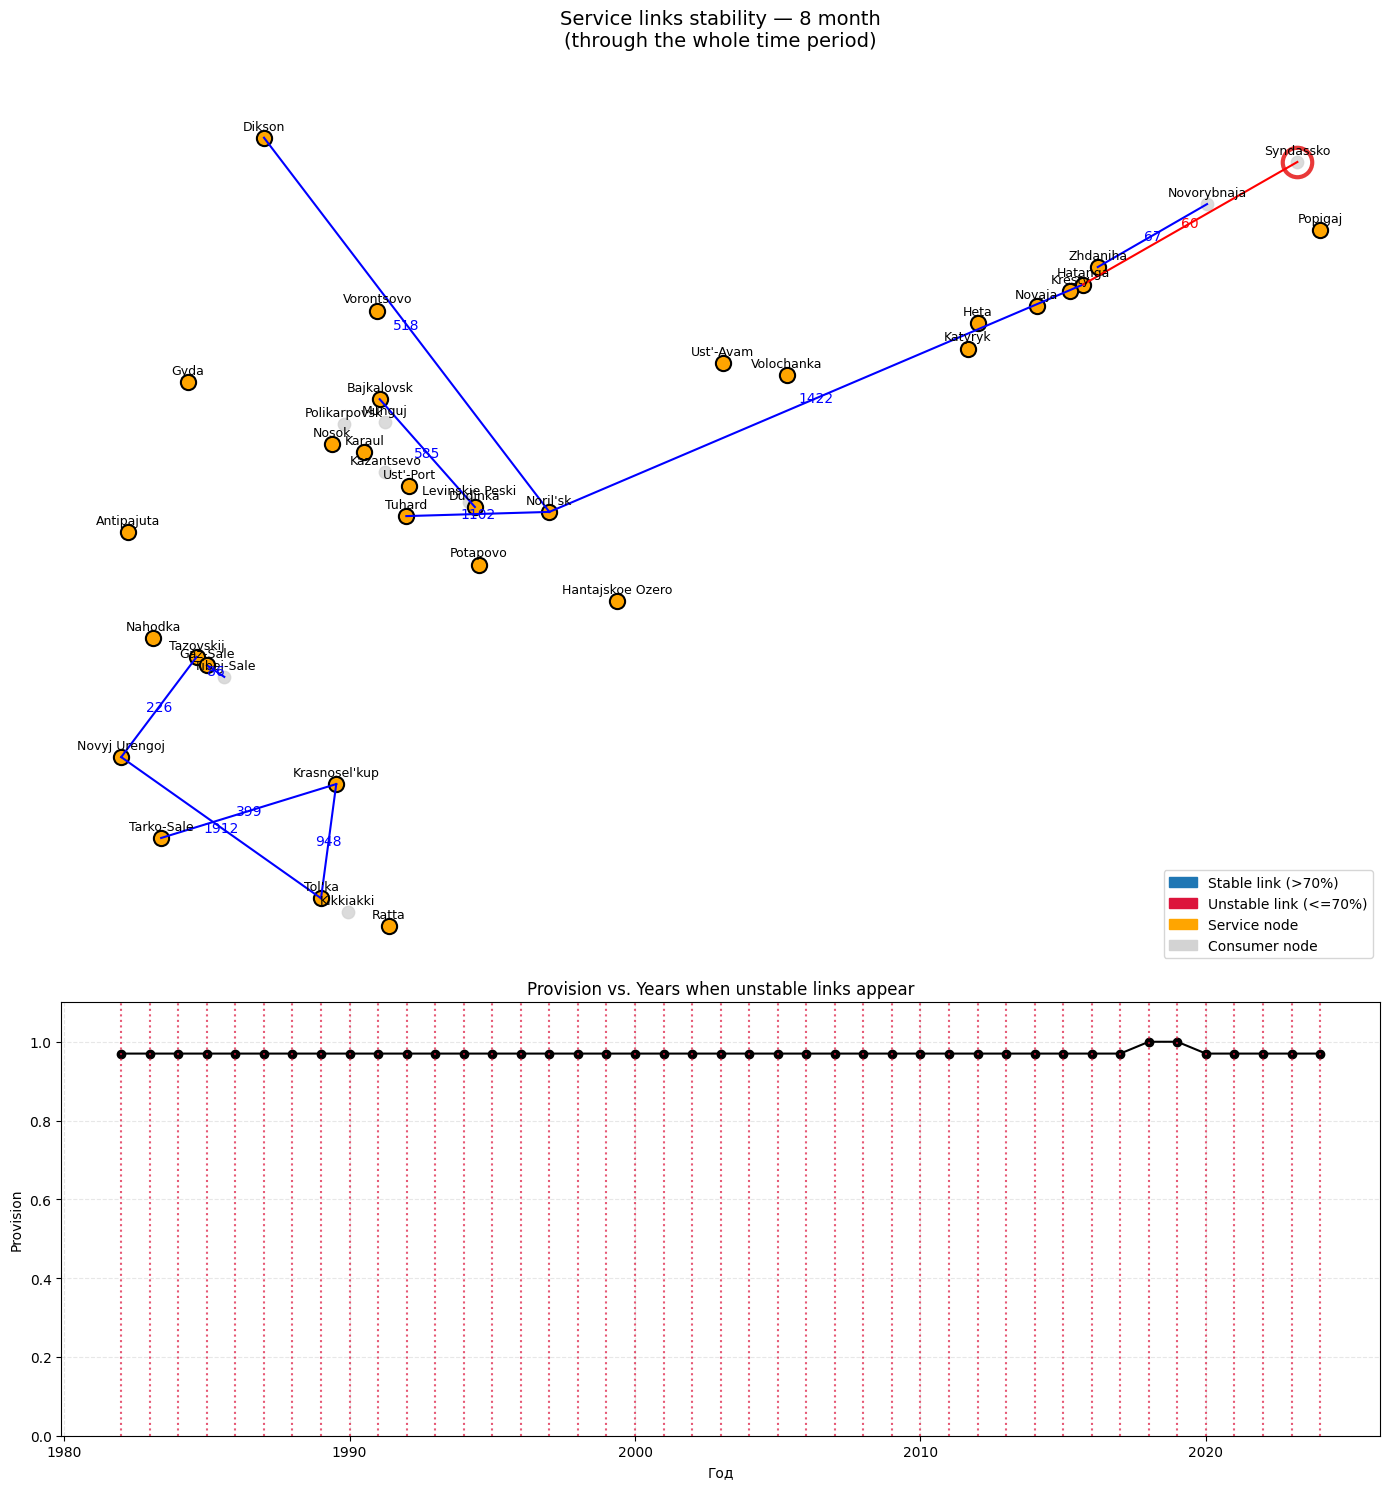

ex:  'Karaul'
ex:  'Volochanka'
ex:  'Hantajskoe Ozero'
ex:  'Potapovo'
ex:  'Zhdaniha'
ex:  'Zhdaniha'
ex:  'Katyryk'
ex:  'Popigaj'
Munguj Nosok
{'weight': 134.0, 'label': 'Water transport', 'temperature': np.int64(4), 'transport_probability': np.float64(0.99184), 'assignment': np.int64(2), 'path': ['Munguj', 'Nosok'], 'is_service_flow': True, 'is_within': True, 'is_service_route': True, 'service_flows': np.int64(2)}
{'weight': 134.0, 'label': 'Water transport', 'temperature': np.int64(1), 'transport_probability': np.float64(0.91683), 'assignment': np.int64(2), 'path': ['Munguj', 'Nosok'], 'is_service_flow': True, 'is_within': True, 'is_service_route': True, 'service_flows': np.int64(2)}
Noril'sk Dudinka
{'weight': 110.0, 'label': 'Winter road', 'temperature': np.int64(3), 'transport_probability': np.float64(0.99632), 'is_service_route': True, 'service_flows': np.int64(183)}
{'weight': 110.0, 'label': 'Winter road', 'temperature': np.int64(1), 'transport_probability': np.float64(0.99

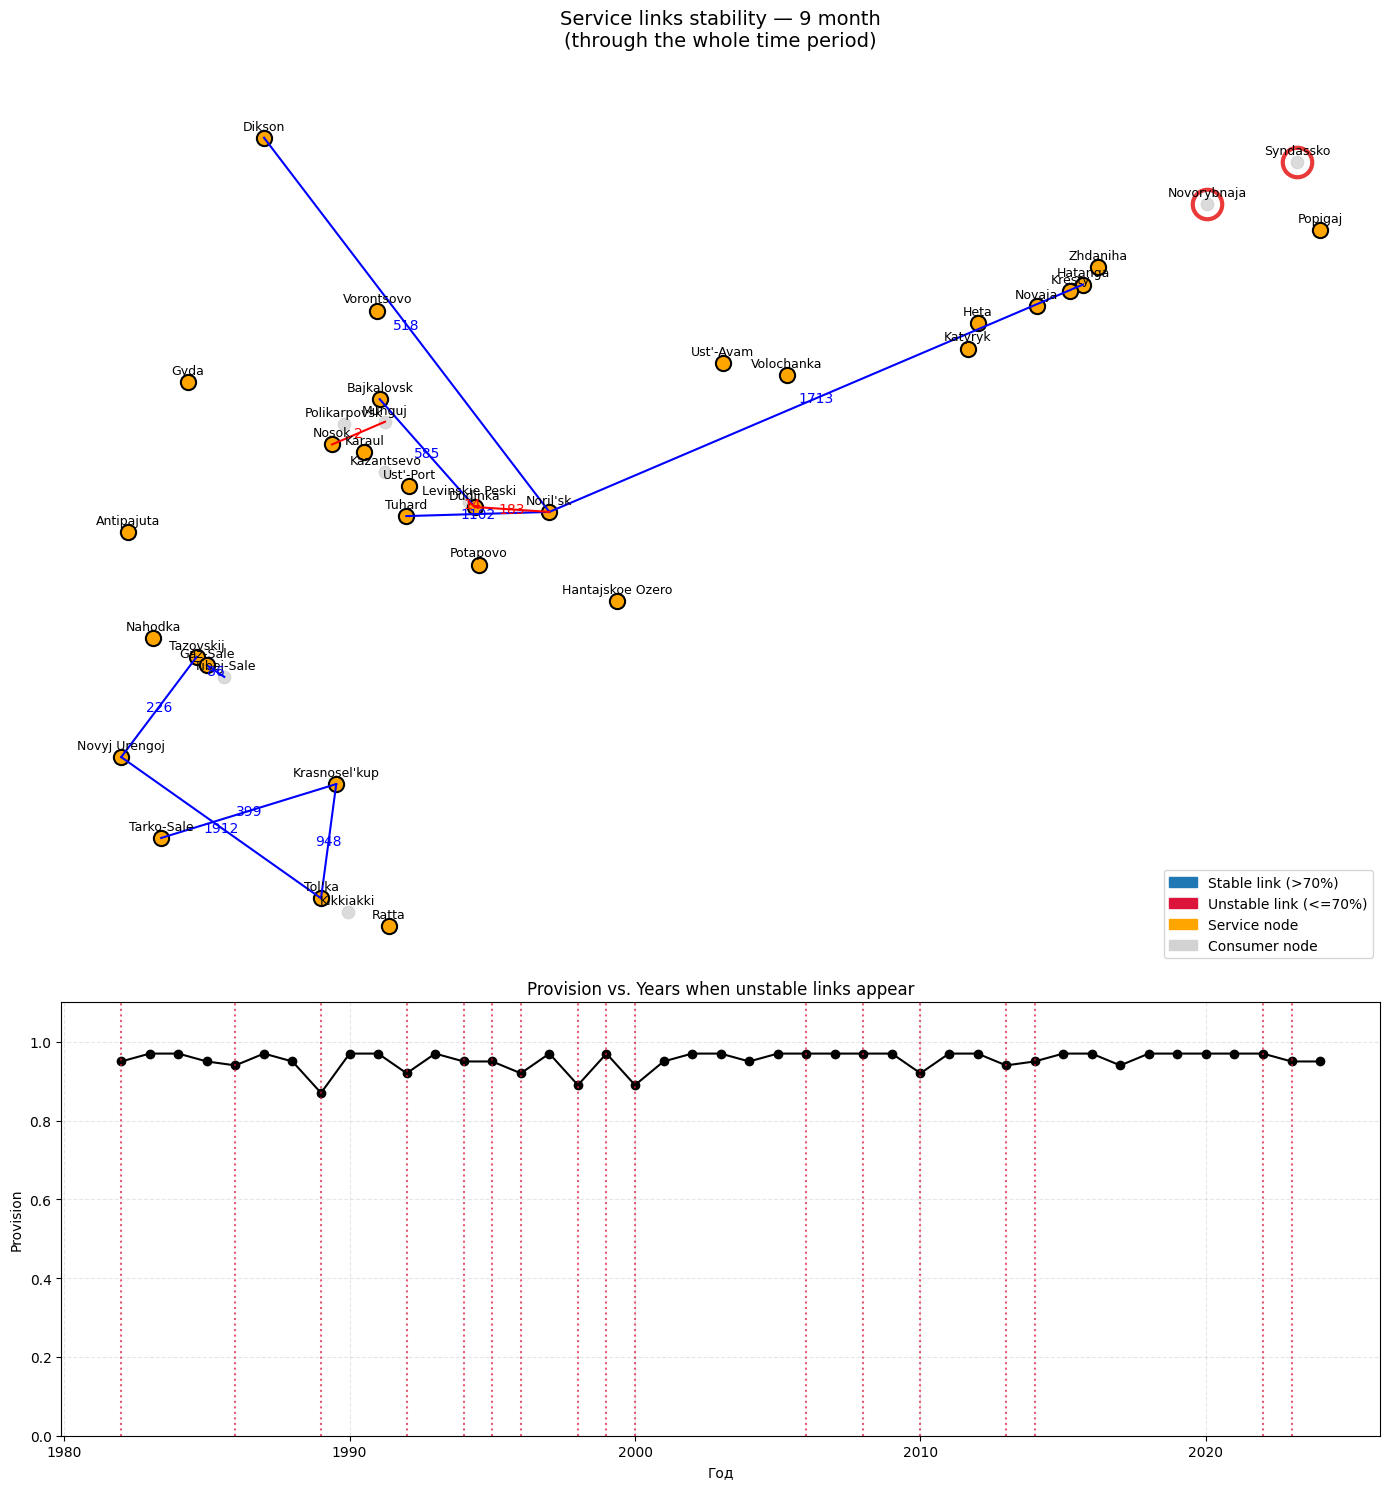

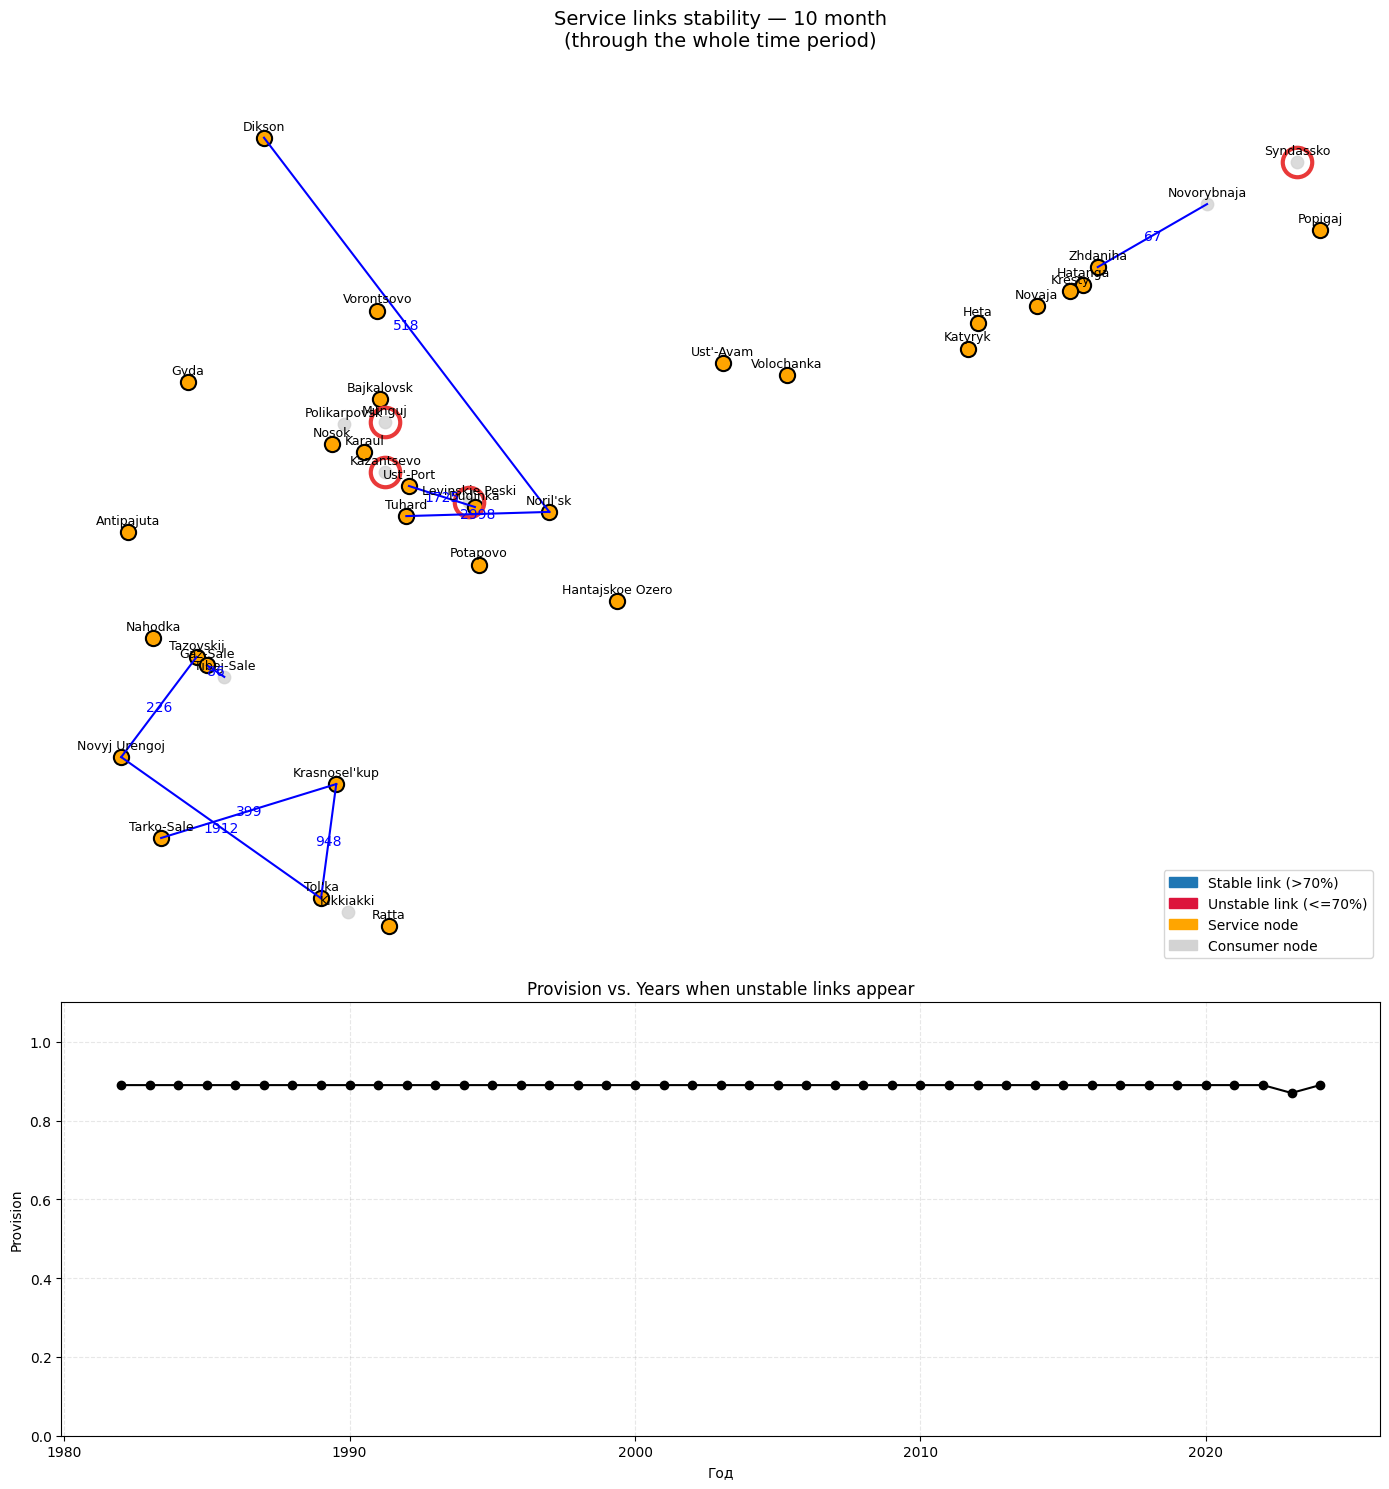

In [ ]:
for m in range(5, 10):
    rare_links, provision = edge_stability_over_years(
        net, month_idx=m, freq=0.7, figsize=(14, 15)
    )


# -- Stop here --

# Выводы (вопросы Любы)

### 1.  prediction of network node attributes (provision type etc.) given structural network node properties (betweenness measures)

In [ ]:
"""
Нет
"""


'\nНет\n'

### 2.  we can represent the network of connectivity between cities  as multilayed network (structuring it by node attributes or by link types), this representation is an alternative  representation of seasonal  data as network structures

In [ ]:
"""
снова по типам ребер? Ну хз скорее нет
"""


'\nснова по типам ребер? Ну хз скорее нет\n'

### 3. Main (hub "опорные") cities selection based on the connectivity types. Depending on the connectivity type we can get separate main hub cities.

In [ ]:
"""
- выделение хабов по разным типам транспорта
-- маршруты через эти хабы
"""


'\n- выделение хабов по разным типам транспорта\n-- маршруты через эти хабы\n'

### 4. Characterisation of critical moments (given structural and node attribute properties). How to distinguish them using network analysis (solely) ?

In [ ]:
"""
- Перечислить что есть эти критичные моменты (без нетворк саенс)
- Перечислить что есть эти критичные моменты (с нетворк саенс)
"""


'\n- Перечислить что есть эти критичные моменты (без нетворк саенс)\n- Перечислить что есть эти критичные моменты (с нетворк саенс)\n'